## <span style="color:blue"> Statement of the problem </span>

This problem requires us to assess the credit risk of potential borrowers by looking at a set of 20 numerical and categorical variables. Even though this data set is old, as evidenced by the old German currency used in the problem, this problem is stil very much relevant today. Lending institutions are always attempting to identify borrowers' credit risk in order to minimize credit losses on their loan portfolios.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import matplotlib as mpl
import math
import os
import itertools

%load_ext autoreload
%autoreload 1
%matplotlib inline

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_union, FeatureUnion, _fit_transform_one, _transform_one
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer
from sklearn.externals.joblib import Parallel, delayed
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

from scipy import sparse
from scipy.stats import chi2_contingency, chi2, ttest_ind

In [3]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot

In [4]:
import MidTerm_Helper as mthelp
%aimport MidTerm_Helper

In [5]:
import warnings
warnings.filterwarnings('ignore')

## <span style="color:blue"> Getting the data </span>

In [6]:
midterm_file = "./data/credit_data.csv"
midterm_df = pd.read_csv(midterm_file)

Checking the number of observations and attributes

In [7]:
dim = midterm_df.shape
print("There are {} observations and {} attributes, including the target.".format(dim[0], dim[1]))

There are 1000 observations and 21 attributes, including the target.


We can see that there are no missing values and that no imputation will be required.

In [8]:
midterm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
Attribute 1     1000 non-null object
Attribute 2     1000 non-null int64
Attribute 3     1000 non-null object
Attribute 4     1000 non-null object
Attribute 5     1000 non-null int64
Attribute 6     1000 non-null object
Attribute 7     1000 non-null object
Attribute 8     1000 non-null int64
Attribute 9     1000 non-null object
Attribute 10    1000 non-null object
Attribute 11    1000 non-null int64
Attribute 12    1000 non-null object
Attribute 13    1000 non-null int64
Attribute 14    1000 non-null object
Attribute 15    1000 non-null object
Attribute 16    1000 non-null int64
Attribute 17    1000 non-null object
Attribute 18    1000 non-null int64
Attribute 19    1000 non-null object
Attribute 20    1000 non-null object
Credit Risk     1000 non-null int64
dtypes: int64(8), object(13)
memory usage: 164.1+ KB


In [9]:
X = midterm_df.drop(axis=1, labels="Credit Risk")
y = midterm_df["Credit Risk"]

Before data exploration, the data set is split into a training set and a test set. This split is done prior to the exploration so the preliminary data analysis will not influenced by the test set. The split was done randomly using the `train_test_split` function in `sklearn`.

An 80:20 split is used for the split. This implies a training set of 800 vs. a test size of 200. I believe that this yields a big enough test set that can properly assess the predictive power of the model. Moreover, I think that the training set is big enough that it will enable me to: (1) capture most of the data set and (2) perform ten-fold cross validation on the training set with enough samples in each validation set.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(800, 20)
(800,)
(200, 20)
(200,)


## <span style="color:blue"> Exploring the data </span>

In the next section, each of the attributes will be analyzed in isolation and in relation to the target variable. The categorical values will be discussed first, followed by the numerical values.

In [12]:
train_data = pd.concat([y_train, X_train], axis=1)

In [13]:
train_data.head()

,Credit Risk,Attribute 1,Attribute 2,Attribute 3,Attribute 4,Attribute 5,Attribute 6,Attribute 7,Attribute 8,Attribute 9,...,Attribute 11,Attribute 12,Attribute 13,Attribute 14,Attribute 15,Attribute 16,Attribute 17,Attribute 18,Attribute 19,Attribute 20
29,2,A11,60,A33,A49,6836,A61,A75,3,A93,...,4,A124,63,A143,A152,2,A173,1,A192,A201
535,2,A13,21,A34,A46,2319,A61,A72,2,A91,...,1,A123,33,A143,A151,1,A173,1,A191,A201
695,1,A14,6,A32,A41,1236,A63,A73,2,A93,...,4,A122,50,A143,A151,1,A173,1,A191,A201
557,2,A14,21,A30,A40,5003,A65,A73,1,A92,...,4,A122,29,A141,A152,2,A173,1,A192,A201
836,1,A14,12,A32,A43,886,A65,A73,4,A92,...,2,A123,21,A143,A152,1,A173,1,A191,A201


### <span style="color:blue"> Target: Credit risk </span>

Each observation is assigned a credit risk of either 1 (good) or 2 (bad). As seen below, around 70% of the observations in the training set were assigned a good rating, while the remaining 30% were assigned a bad rating. Therefore, if we know nothing about a particular observation, the best guess is to assign a Credit Risk = 1 to that observation. Obviously, if this very naive model is applied to this data set, this model will have an accuracy score of 70%.

,1,2
Credit Risk,70%,30%


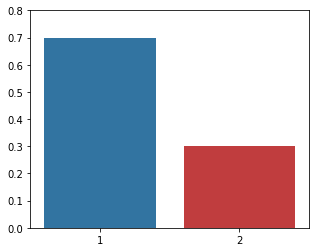

In [14]:
mthelp.plot_table_attr(train_data, "Credit Risk", palette=["tab:blue", "tab:red"])

### <span style="color:blue"> Categorical variables </span>

All of the categorical variables, together with the range of possible values for each, will be discussed below. A hypothesis about the relationship between the categorical attribute and the target value will sometimes be given. The distribution of the attribute, not only for the entire training set but also for the set of observations with good credit and the set of observations with bad credit, will be analyzed. The independence between each categorical variable and the target variable will also be tested using $\chi^2$-tests. 

### <span style="color:blue"> Attribute 1: Status of checking account </span>

This attribute is a categorical feature that has four possible values:
* A11: Checking account has < 0 DM
* A12: Account contains >= 0 DM but < 200 DM
* A13: Account contains >= 200 DM or salary assignments** for at least a year
* A14: No checking account

** <i> A salary assignment gives the lender the right to take money directly from the borrower's paycheck in order to pay back the loan. </i>

Given the descriptions above, it is reasonable to expect that there will be more A11 observations among the bad borrowers vs. the good borrowers. Moreover, there will be more A13 observations among the good borrowers vs. the bad borrowers. This is because we expect one's creditworthiness to increase with his/her account balance.

Below is the distribution of the four categories in training set. Almost 40% of the observations had no checking accounts.

,A11,A12,A13,A14
Attribute 1,27%,27%,6%,40%


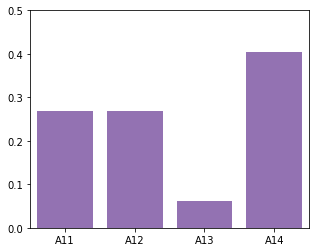

In [15]:
mthelp.plot_table_attr(train_data, "Attribute 1")

When we split the training set into good vs. bad credit, we can see a drastic difference in the distribution of the values of Attribute 1 between these two sets. Here are some observations:
* Among the good borrowers, only 19% had a negative balance on their checking account, compared to 44% among the bad-credit borrowers.
* 7% of the good borrowers had more than 200 DM / salary assignments on their accounts, compared to only 4% among the high-risk borrowers.
* The observations above confirm our hypothesis.
* 23% of the good borrowers had a checking account balance of 0-200 DM, compared to 35% among the high-risk borrowers.
* It is noteworthy that 50% of the good credit observations have no checking accounts, compared to only 18% among the bad credit observations.

All of these observations imply that the status of one's checking account have an effect on credit risk. More specifically, the higher the account balance, the better the credit risk.

Credit Risk,1,2
Attribute 1,,
A11,19.50%,43.57%
A12,23.43%,34.44%
A13,6.98%,4.15%
A14,50.09%,17.84%


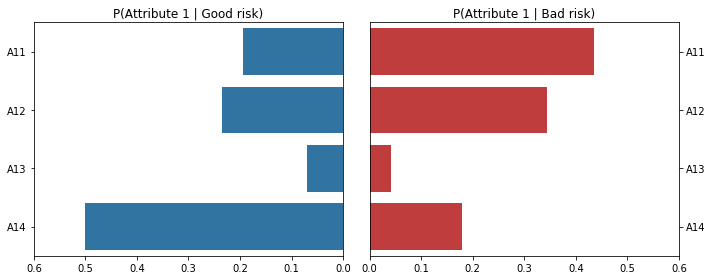

In [16]:
mthelp.plot_table_cond_attr(train_data, "Attribute 1")

,A11,A12,A13,A14,All
Credit Risk,,,,,
1,50.93%,61.21%,79.59%,86.69%,69.88%
2,49.07%,38.79%,20.41%,13.31%,30.12%


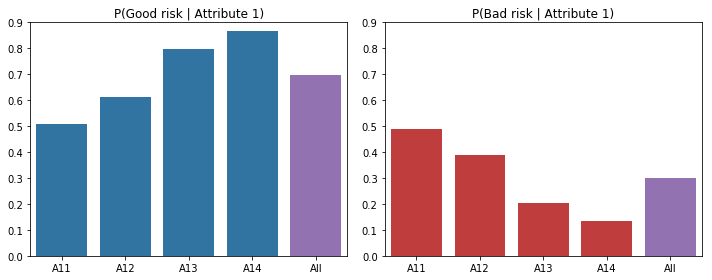

In [17]:
mthelp.plot_prob_attr(train_data, "Attribute 1")

This hypothesis is verified using a $\chi^2$-test. This statistical test is typically used to determine if there is an association between two categorical variables. In this case, the categorical variables being tested are credit risk and the status of the checking account. More specifically, this test checks whether the distribution of the values of Attribute 1, when split between good and bad credit sets, is significantly different from the distribution of Attribute 1 in the overall data set. The test can also be interpreted as a test of independence between two variables.

For this test, the hypotheses are:
* $H_0$: Credit risk and Attribute 1 are independent.
* $H_a$: Credit risk and Attribute 1 are not independent.

The figures below show the result of a $\chi^2$-test with an $\alpha$ of 0.05. Given the critical value and the p-value below, we reject the null hypothesis that Credit Risk and Attribute 1 are independent.

In [18]:
mthelp.chi2_test(train_data, "Attribute 1", alpha=0.05)

Chi-square statistic: 89.6648
Critical value: 7.8147
alpha: 0.0500
p-value: 2.59e-19


To further check the source of dependence between the two, the $\chi^2$-test is done on individual values of Attribute 1. For example, the $\chi^2$-test is used to check whether credit risk is independent from Attribute 1 being equal to A11. In this instance, the hypotheses are as follows:
* $H_0$: Credit risk and having an Attribute 1 = A11 are independent.
* $H_a$: Credit risk and having an Attribute 1 = A11 are not independent.

The test described above is done for all possible values of Attribute 1. The table below shows the results of the individual $\chi^2$-tests. Given these, there is enough evidence to believe that knowing that Attribute 1 has a value of A11, A12, or A14 will have an effect on our guess of an observation's credit risk. We cannot say the same if Attribute 1 is equal to A13. This is because there are fewer observations with Attribute 1 = A13 (only 6% of the entire training set).

In [19]:
mthelp.attr_chi2_test(train_data, "Attribute 1")

Attribute 1,A11,A12,A13,A14
Chi-stat,48.5686,9.8547,1.8753,71.4077
p-values,3.19e-12,0.0017,0.1709,2.91e-17


The same types of analysis (plots, tables, chi-square tests) will be done on the other categorical variables.

In [20]:
attr_summary={}
attr_summary["Attr 01"] = ["Checking account", "Categorical", "Significant, chi2-test",
                                "Higher account balance, better credit"]

### <span style="color:blue"> Attribute 3: Credit history </span>

This attribute is a categorical feature that has five possible values:
* A30: No prior credits taken / all credits paid back duly
* A31: All credits at this bank paid back duly
* A32: Existing credits paid back duly until now
* A33: Delay in paying off in the past
* A34: Critical account / other credits existing (not at this bank)

Given the descriptions above, we expect more A30 and A31 among the good borrowers vs. the bad borrowers. Similarly, we should expect more A33 and and A34 among the bad borrowers vs. the good borrowers. This is because credit history is a good measure of one's future creditworthiness, especially if we expect one's creditworthiness to be relatively stable over time.

Below is the distribution of the five categories in training set. Most of the borrowers (almost 53%) have duly paid back their existing credits until now (A32). Almost 30% have critical accounts or credits with other banks.

,A30,A31,A32,A33,A34
Attribute 3,4%,5%,52%,9%,29%


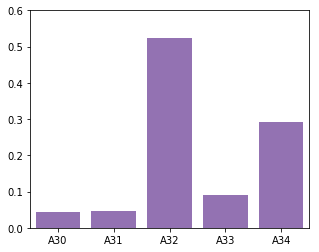

In [21]:
mthelp.plot_table_attr(train_data, "Attribute 3")

Interestingly, the graphs below show that the initial hypotheses about Attribute 3 are incorrect. There are more A34 among the good credit set vs. the bad credit set. There are also more A30 and A31 among the bad credit set vs. the good credit set. These imply that, in this data set, good credit history does not necessarily imply good credit risk. Contrary to intuition, these two seem to actually have an inverse relationship.

Credit Risk,1,2
Attribute 3,,
A30,2.15%,9.54%
A31,2.86%,9.13%
A32,50.98%,56.02%
A33,9.12%,9.13%
A34,34.88%,16.18%


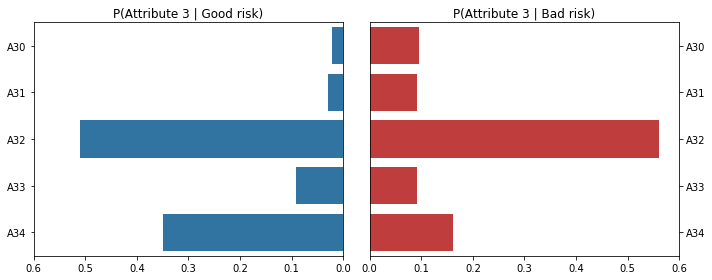

In [22]:
mthelp.plot_table_cond_attr(train_data, "Attribute 3", normalize=True)

,A30,A31,A32,A33,A34,All
Credit Risk,,,,,,
1,34.29%,42.11%,67.86%,69.86%,83.33%,69.88%
2,65.71%,57.89%,32.14%,30.14%,16.67%,30.12%


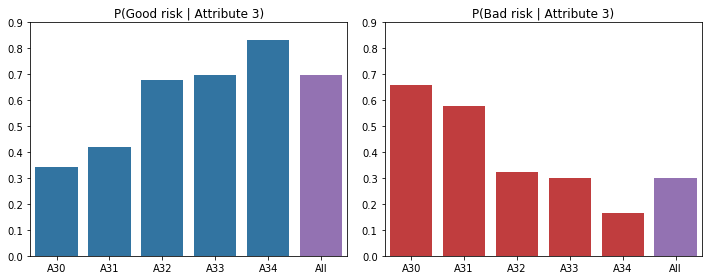

In [23]:
mthelp.plot_prob_attr(train_data, "Attribute 3")

To further check the association between credit history and credit risk, we again conduct a $\chi^2$-test on these variables. The results below show that there is an association (with 95% confidence) between credit risk and credit history. However, this association is most likely negative (i.e., good history is more indicative of higher risk), contrary to the initial hypothesis.

In [24]:
mthelp.chi2_test(train_data, "Attribute 3", alpha=0.05)

Chi-square statistic: 55.9285
Critical value: 9.4877
alpha: 0.0500
p-value: 2.08e-11


Further testing suggest that knowing that Attribute 3 has a value of either A32 or A33 will not have a significant effect on our guess of credit risk. This is because, as seen in the graph above, the probablity of having good credit given that Attribute 3 is equal to A32 or A33 is very close to 70%, the percentage of accounts with good credit in the entire training set.

In [25]:
mthelp.attr_chi2_test(train_data, "Attribute 3")

Attribute 3,A30,A31,A32,A33,A34
Chi-stat,20.2909,13.2633,1.5145,0.0173,27.5627
p-values,6.65e-06,2.71e-04,0.2185,0.8954,1.52e-07


In [26]:
attr_summary["Attr 03"] = ["Credit history", "Categorical", "Significant, chi2-test",
                          "Better to focus on following values: A30, A31, A34"]

### <span style="color:blue"> Attribute 4: Purpose </span>

This pertains to the reason why the borrower applied for a loan. Below are the possible values of this categorical variable:
* A40 : Car (new)
* A41 : Car (used)
* A42 : Furniture/equipment
* A43 : Radio/television
* A44 : Domestic appliances
* A45 : Repairs
* A46 : Education
* A47 : Vacation
* A48 : Retraining
* A49 : Business
* A410 : Others

The table and the bar graph below show that the loan is usually used to buy radio/television (28%), followed by new cars (24%). Unlike the previously discussed variables, it is harder to guess what the relationship of this variable is to credit risk.

,A40,A41,A410,A42,A43,A44,A45,A46,A48,A49
Attribute 4,24%,10%,1%,17%,28%,1%,2%,5%,1%,10%


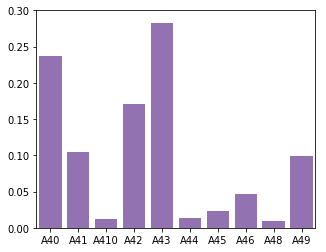

In [27]:
mthelp.plot_table_attr(train_data, "Attribute 4")

Based on the table and graph below, the set of observations with good credit have a higher proportion of borrowers whose Attribute 4 is A41 and A43, compared to the entire training set. This tells us that if the loan is used to buy a used car or radio/television, there is a higher chance that the borrower has good credit risk.

On the other hand, observations with bad credit have a higher proportion of borrowers whose Attribute 4 is A40, A410, A44, A46, and A49, compared to the entire training set.

Credit Risk,1,2
Attribute 4,,
A40,20.75%,30.71%
A41,12.16%,6.64%
A410,0.89%,2.07%
A42,16.99%,17.43%
A43,32.02%,19.50%
A44,1.25%,1.66%
A45,2.33%,2.49%
A46,3.40%,7.47%
A48,1.07%,0.41%


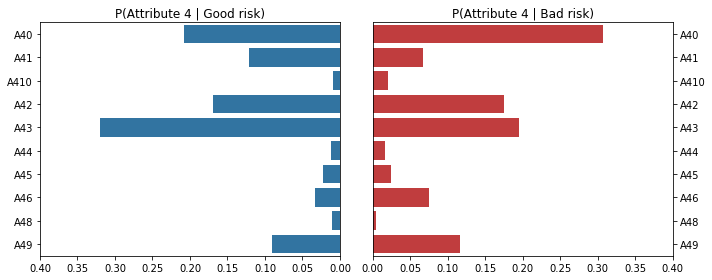

In [28]:
mthelp.plot_table_cond_attr(train_data, "Attribute 4")

Looking at the left graph below, the following values for Attribute 4 imply a higher probability of being assigned a good credit risk compared to the entire training set: A41 (used car), A43 (radio/television), and A48 (retraining).

,A40,A41,A410,A42,A43,A44,A45,A46,A48,A49,All
Credit Risk,,,,,,,,,,,
1,61.05%,80.95%,50.00%,69.34%,79.20%,63.64%,68.42%,51.35%,85.71%,64.56%,69.88%
2,38.95%,19.05%,50.00%,30.66%,20.80%,36.36%,31.58%,48.65%,14.29%,35.44%,30.12%


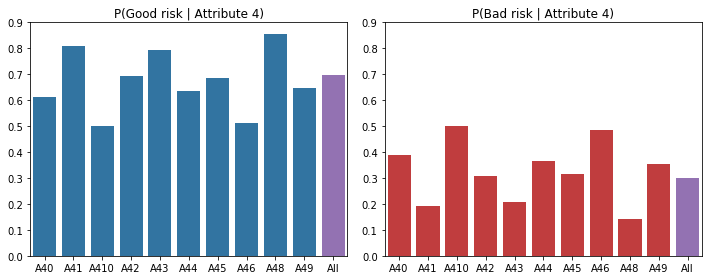

In [29]:
mthelp.plot_prob_attr(train_data, "Attribute 4")

This $\chi^2$-test imply that credit risk and Attribute 4 are not independent.

In [30]:
mthelp.chi2_test(train_data, "Attribute 4", alpha=0.05)

Chi-square statistic: 31.3096
Critical value: 16.9190
alpha: 0.0500
p-value: 2.62e-04


However, if individual tests are done on all possible values of Attribute 4, only for the following values can we reject the null hypothesis of the test: A40 (new car), A41 (used car), A43 (radio/television), and A46 (education).

Based on our previous graphs and tables, A40 and A46 imply a higher chance of a bad credit risk compared to the entire set. On the other hand, A41 and A43 imply a higher chance of a good credit risk compared to the entire set.

In [31]:
mthelp.attr_chi2_test(train_data, "Attribute 4")

Attribute 4,A40,A41,A410,A42,A43,A44,A45,A46,A48,A49
Chi-stat,8.6723,4.8990,1.0645,0.0022,12.4113,0.0152,0.0128,5.4347,0.2537,0.9141
p-values,0.0032,0.0269,0.3022,0.9627,4.27e-04,0.9019,0.9098,0.0197,0.6145,0.3390


In [32]:
attr_summary["Attr 04"] = ["Purpose", "Categorical", "Significant, chi2-test",
                               "Better to focus on following values: A40, A41, A43, A46"]

### <span style="color:blue"> Attribute 6: Savings account / bonds </span>

This variable corresponds to the value of the borrowers' savings account / bonds, bucketized into the following categories:
* A61: Less than 100 DM
* A62: At least 100 DM but less than 500 DM
* A63: At least 500 DM but less than 1,000 DM
* A64: At least 1,000 DM
* A65: Unknown or no savings account

The logical hypothesis here is that one's savings account balance is positively correlated with creditworthiness. We expect those with A61 and A62 to be riskier than A63 and A64.

The graph below shows that majority (59%) of the observations have Attribute 6 equal to A61 while only 5% have A64. 

,A61,A62,A63,A64,A65
Attribute 6,59%,10%,7%,5%,19%


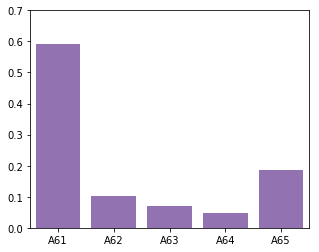

In [33]:
mthelp.plot_table_attr(train_data, "Attribute 6", normalize=True)

As expected, the savings account balance does seem to affect one's risk. There seem to be a higher proportion of A61 and A62 accounts among the set of observations with bad credit risk compared to the set with good credit risk. Similarly, there is a higher proportion of A63 and A64 accounts among those with good credit risk compared to those with bad credit risk. There seem to be a higher proportion of observations with no accounts in the good credit risk set.

Credit Risk,1,2
Attribute 6,,
A61,55.10%,68.88%
A62,9.48%,12.03%
A63,8.23%,4.15%
A64,6.08%,2.07%
A65,21.11%,12.86%


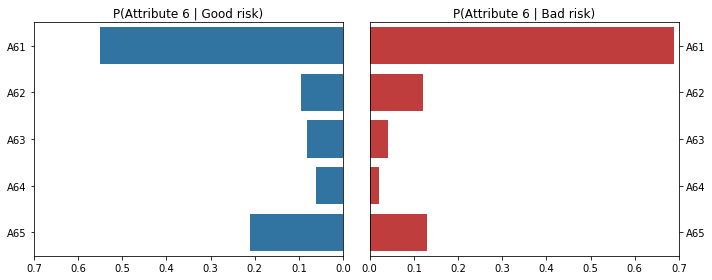

In [34]:
mthelp.plot_table_cond_attr(train_data, "Attribute 6")

The observations above are consistent with the conditional probability plots below.

,A61,A62,A63,A64,A65,All
Credit Risk,,,,,,
1,64.98%,64.63%,82.14%,87.18%,79.19%,69.88%
2,35.02%,35.37%,17.86%,12.82%,20.81%,30.12%


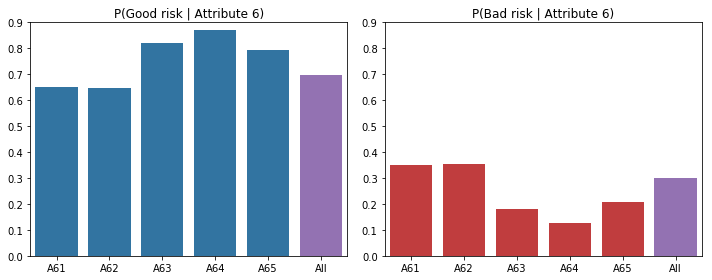

In [35]:
mthelp.plot_prob_attr(train_data, "Attribute 6")

Based on the results of the $\chi^2$-test below, we reject the null hypothesis that Attribute 6 and credit risk are independent. We can say that there is significant evidence to assume that these two variables are associated with each other.

In [36]:
mthelp.chi2_test(train_data, "Attribute 6", alpha=0.05)

Chi-square statistic: 22.1677
Critical value: 9.4877
alpha: 0.0500
p-value: 1.86e-04


Of the five possible values of Attribute 6, only the value A62 failed the individual $\chi^2$-test, as seen in the table of p-values below.

In [37]:
mthelp.attr_chi2_test(train_data, "Attribute 6")

Attribute 6,A61,A62,A63,A64,A65
Chi-stat,12.6819,0.9309,3.7013,5.0001,7.0209
p-values,3.69e-04,0.3346,0.0544,0.0253,0.0081


In [38]:
attr_summary["Attr 06"] = ["Savings account / bonds", "Categorical", "Significant, chi2-test",
                            "Higher savings / bond value, better credit"]

### <span style="color:blue"> Attribute 7: Length of time in present employment </span>

This variable corresponds to the number of years that the borrower has been with his/her current employer, bucketized into the following categories:
* A71: Unemployed
* A72: Employed for less than one year
* A73: At least one year but less than four years
* A74: At least four years but less than seven
* A75: At least seven years

The logical hypothesis here is that those who have been with their current employer the longest have more stable careers and thus a better credit risk. Conversely, we expect unemployed borrowers to have bad credit risk.

Most of the borrowers have been with their employers for at least a year but less than four years (A73). Only 7% are unemployed (A71).

,A71,A72,A73,A74,A75
Attribute 7,7%,17%,34%,18%,25%


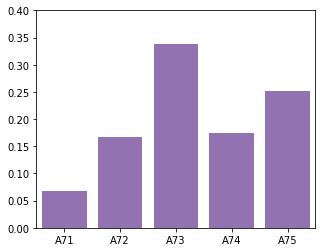

In [39]:
mthelp.plot_table_attr(train_data, "Attribute 7")

As expected, there is a higher proportion of unemployed borrowers among those assigned with bad credit risk vs. those assigned with good credit risk. Similarly, there is a higher proportion of A75 (at least seven years) observations among the good credit risk set vs. the bad credit risk set. There doesn't seem to be a significant difference between the proportion of A73 observations in the good credit set and the bad credit set.

Credit Risk,1,2
Attribute 7,,
A71,5.90%,8.71%
A72,14.67%,21.58%
A73,33.09%,35.27%
A74,18.43%,15.35%
A75,27.91%,19.09%


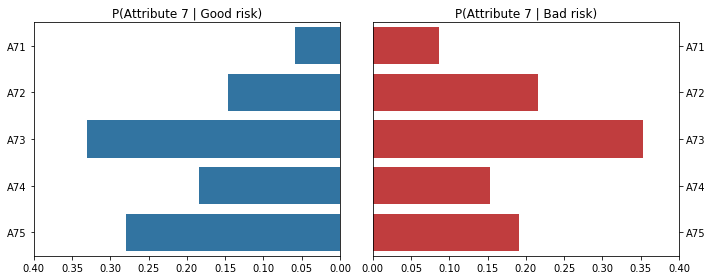

In [40]:
mthelp.plot_table_cond_attr(train_data, "Attribute 7")

This is supported by the plots of conditional probabilities below. A71 and A72 observations have a below-average probability of being assigned good credit. On the other hand, A74 and A75 observations have an above-average probability of being assigned bad credit.

,A71,A72,A73,A74,A75,All
Credit Risk,,,,,,
1,61.11%,61.19%,68.52%,73.57%,77.23%,69.88%
2,38.89%,38.81%,31.48%,26.43%,22.77%,30.12%


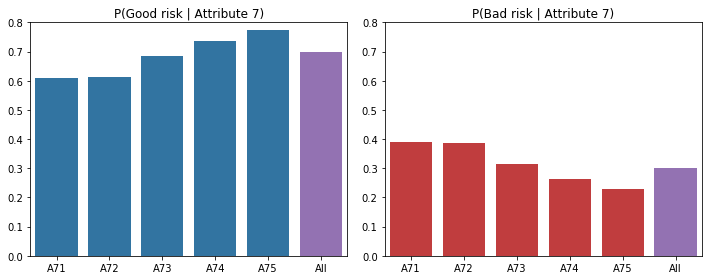

In [41]:
mthelp.plot_prob_attr(train_data, "Attribute 7")

The $\chi^2$-test allows us to reject the null hypothesis that credit risk and Attribute 7 are independent.

In [42]:
mthelp.chi2_test(train_data, "Attribute 7", alpha=0.05)

Chi-square statistic: 13.1003
Critical value: 9.4877
alpha: 0.0500
p-value: 0.0108


However, based on the individual $\chi^2$-tests done for each value of Attribute 7, only the values A72 (less than one year) and A75 (at least seven years) would show significant p-values. This makes sense for A73 and A74 because we expect the relationship between Attribute 7 and credit risk to not be as straightforward in this middle range. For A71, the lack of significance is explained by the relatively lower amount of observations (only 7%) that are unemployed.

In [43]:
mthelp.attr_chi2_test(train_data, "Attribute 7")

Attribute 7,A71,A72,A73,A74,A75
Chi-stat,1.6901,5.2777,0.2656,0.8989,6.4810
p-values,0.1936,0.0216,0.6063,0.3431,0.0109


Given the results above, it might be better to create fewer categories:
* Category 1: A71 and A72
* Category 2: A73 and A74
* Category 3: A75

In [44]:
attr_summary["Attr 07"] = ["Time in present employment", "Categorical", "Significant, chi2-test",
                           "Better to create fewer categories: (1) A71 and A72, (2) A73 and A74, and (3) A75"]

### <span style="color:blue"> Attribute 9: Sex and marital status </span>

This variable is a cross feature combining sex and marital status with the following values:
* A91: Male, divorced/separated
* A92: Female, divorced/separated/married
* A93: Male, single
* A94: Male, married/widowed
* A95: Female, single

Based on cursory research, there is evidence of gender pay gap in Germany. This would lead us to hypothesize that given two individuals with the same marital status but opposite sex, the male would have a higher salary and, perhaps better credit risk.

The graph below shows that most of the borrowers are single males (55%). On the other hand, there are no single female borrowers.

,A91,A92,A93,A94
Attribute 9,4%,32%,55%,9%


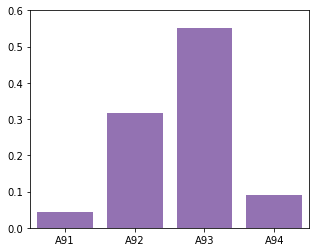

In [45]:
mthelp.plot_table_attr(train_data, "Attribute 9")

There seem to be a higher proportion of single males in the good credit risk set vs. the bad credit risk set. On the other hand, there are relatively more divorced/separated/married women in the bad credit risk compared to the good credit risk set.

Credit Risk,1,2
Attribute 9,,
A91,3.76%,5.39%
A92,28.98%,38.17%
A93,58.14%,47.72%
A94,9.12%,8.71%


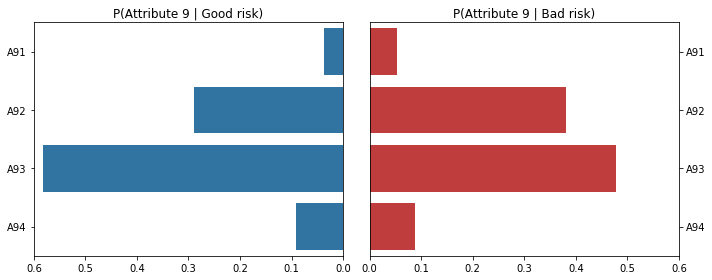

In [46]:
mthelp.plot_table_cond_attr(train_data, "Attribute 9")

Of the four buckets, separated males seem to have the highest probability of being assigned with a bad risk category. However, it is worth noting that this is the category with the least observations.

,A91,A92,A93,A94,All
Credit Risk,,,,,
1,61.76%,63.78%,73.86%,70.83%,69.88%
2,38.24%,36.22%,26.14%,29.17%,30.12%


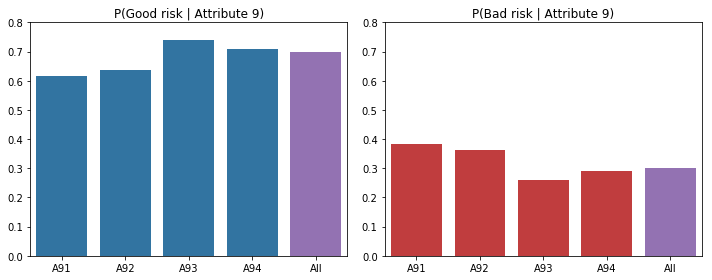

In [47]:
mthelp.plot_prob_attr(train_data, "Attribute 9")

The p-value below allows us to reject the null hypothesis that Attribute 9 and credit risk are independent with $\alpha$ = 0.05. However, we would not be able to reject this hypothesis with $\alpha$ = 0.01.

In [48]:
mthelp.chi2_test(train_data, "Attribute 9", alpha=0.05)

Chi-square statistic: 8.9026
Critical value: 7.8147
alpha: 0.0500
p-value: 0.0306


Of the four possible values of Attribute 9, only A92 (divorced/separated/married females) and A93 (single males) show significantly different probabilities of being assigned good credit vs. the overall population. Divorced/separated/married females have a below-average probability, while single males have an above-average probability of belonging in the good credit set.

In [49]:
mthelp.attr_chi2_test(train_data, "Attribute 9")

Attribute 9,A91,A92,A93,A94
Chi-stat,0.7437,6.1515,6.9748,0.0026
p-values,0.3885,0.0131,0.0083,0.9592


In [50]:
attr_summary["Attr 09"] = ["Sex and marital status", "Categorical", "Significant, chi2-test", ""]

### <span style="color:blue"> Attribute 10: Other debtors/guarantors </span>

This is a categorical value with the following possible values:
* A101: There is only one borrower with no guarantor
* A102: Borrower has a co-applicant
* A103: Borrower has a guarantor (party willing to shoulder the loan if the borrower defaults)

The presence of a guarantor, especially an affluent one, could increase the creditworthiness of a borrower.

The graph below shows that a significant majority of borrowers (90%) did not have a co-applicanot or guarantor.

,A101,A102,A103
Attribute 10,90%,4%,6%


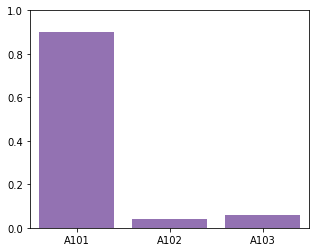

In [51]:
mthelp.plot_table_attr(train_data, "Attribute 10")

There does not seem to be a difference between the distribution of the values of Attribute 10 in the good credit set vs. the bad credit set.

Credit Risk,1,2
Attribute 10,,
A101,89.62%,90.87%
A102,3.94%,4.98%
A103,6.44%,4.15%


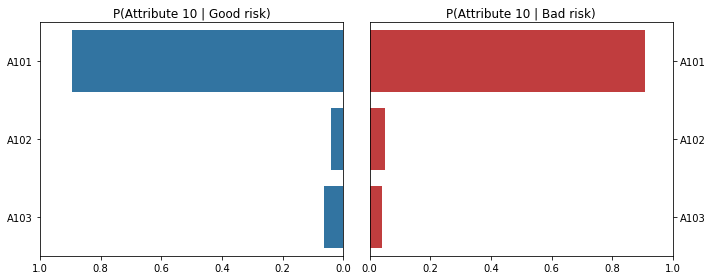

In [52]:
mthelp.plot_table_cond_attr(train_data, "Attribute 10")

Borrowers with co-applicants (A102) have a lower probability of being in the good credit set than the overall training set. It is the opposite for those with guarantors (A103). However, it is worth noting that those with guarantors and co-applicants only comprise 10% of the entire training set.

,A101,A102,A103,All
Credit Risk,,,,
1,69.58%,64.71%,78.26%,69.88%
2,30.42%,35.29%,21.74%,30.12%


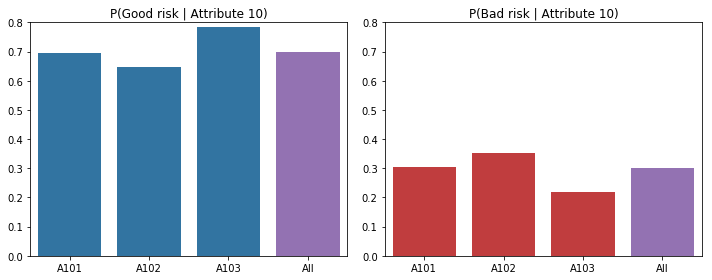

In [53]:
mthelp.plot_prob_attr(train_data, "Attribute 10")

Based on the results of the $\chi^2$-tests below, we cannot reject the null hypothesis that Attribute 10 and credit risk are independent. This is partly because an ov3rwhelming majority of the observations had the same Attribute 10 value. This makes the good-bad split of the A101 observations virtually the same as the good-bad split of the entire training set.

In [54]:
mthelp.chi2_test(train_data, "Attribute 10", alpha=0.05)

Chi-square statistic: 1.9974
Critical value: 5.9915
alpha: 0.0500
p-value: 0.3684


Because of the very small size of observations with guarantors and co-applications, these observations are not enough to imply a significant association between credit risk and Attribute 10.

In [55]:
mthelp.attr_chi2_test(train_data, "Attribute 10")

Attribute 10,A101,A102,A103
Chi-stat,0.1689,0.2308,1.2352
p-values,0.6811,0.6310,0.2664


In [56]:
attr_summary["Attr 10"] = ["Other debtors / guarantors", "Categorical", "Not significant, chi2-test", ""]

### <span style="color:blue"> Attribute 12: Property owned by the borrower </span>

This is a categorical value with the following possible values:
* A121: Real estate
* A122: If not real estate, building society savings agreement / life insurance
* A123: If not A121 or 122, car or other assets not included in Attribute 6
* A124: Unknown or no property

The presence of a high-value asset such as real estate would imply one's good credit quality. Moreover, properties could be used as collateral for loans, reducing the loan's credit risk. Therefore, we expect borrowers with real estate to have higher creditworthiness than average and those with no properties to have worse credit risks.

The graph below shows that most borrowers are in category A123 (34%). Only 15% have unknown or no property.

,A121,A122,A123,A124
Attribute 12,28%,24%,34%,15%


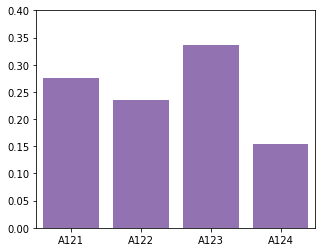

In [57]:
mthelp.plot_table_attr(train_data, "Attribute 12")

As exected, there is a higher percentage of borrowers with real estate in the good credit risk set. On the other hand, there are more borrowers under category A123 and A124 in the bad credit risk set. The proportion of borrowers with category A122 are virtually the same under the two sets.

Credit Risk,1,2
Attribute 12,,
A121,31.48%,18.26%
A122,23.43%,23.65%
A123,32.74%,35.68%
A124,12.34%,22.41%


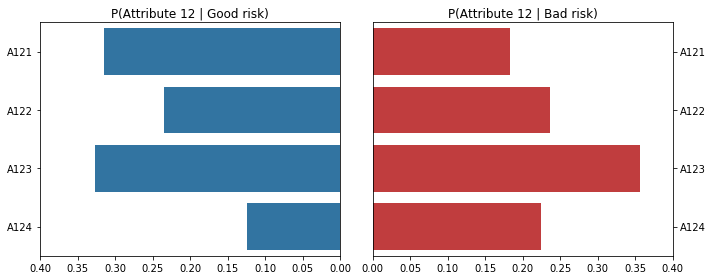

In [58]:
mthelp.plot_table_cond_attr(train_data, "Attribute 12")

The observations above are in line with the conditional probabilities shown below. This suggest that property may have some association with credit risk.

,A121,A122,A123,A124,All
Credit Risk,,,,,
1,80.00%,69.68%,68.03%,56.10%,69.88%
2,20.00%,30.32%,31.97%,43.90%,30.12%


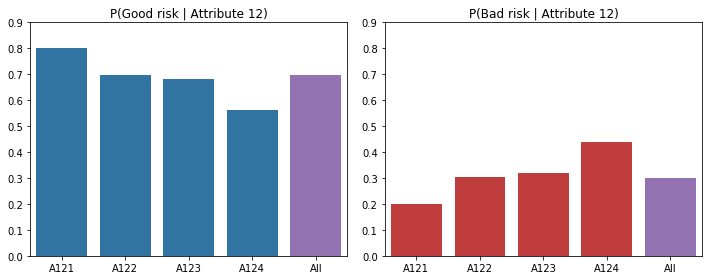

In [59]:
mthelp.plot_prob_attr(train_data, "Attribute 12")

This hypothesis is confirmed by the results of the $\chi^2$-test below, which shows are very small p-value.

In [60]:
mthelp.chi2_test(train_data, "Attribute 12", alpha=0.05)

Chi-square statistic: 22.2444
Critical value: 7.8147
alpha: 0.0500
p-value: 5.80e-05


However, only category A121 and A124 seem to be good predictors of credit risk, with A121 implying good credit and A124 implying bad credit. Because the good-bad split under A122 and A123 are virtually the same as the entire set, these will not be good predictors.

In [61]:
mthelp.attr_chi2_test(train_data, "Attribute 12")

Attribute 12,A121,A122,A123,A124
Chi-stat,14.1223,6.02e-04,0.5301,12.3447
p-values,1.71e-04,0.9804,0.4665,4.42e-04


In [62]:
attr_summary["Attr 12"] = ["Property owned", "Categorical", "Significant, chi2-test",
                           "Better to focus on following values: A121, A124"]

### <span style="color:blue"> Attribute 14: Other installment plans </span>

This is a categorical value with the following possible values:
* A141: Bank
* A142: Stores
* A143: None

An installment plan is an arrangement to pay something in installments. The presence of one could reduce one's cash flow available for servicing the loan. Thus, we expect observations under category A143 to have relatively higher creditworthiness.

Most of the borrowers (82%) did not have any other installment plans.

,A141,A142,A143
Attribute 14,14%,4%,82%


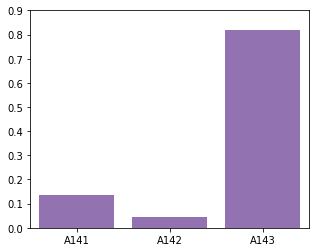

In [63]:
mthelp.plot_table_attr(train_data, "Attribute 14")

The graph below confirms our hypothesis. There are relatively more A141 (with bank installments) and A142 (with store installments) observations in the bad risk set compared to the good risk set.

Credit Risk,1,2
Attribute 14,,
A141,11.27%,19.09%
A142,3.94%,5.39%
A143,84.79%,75.52%


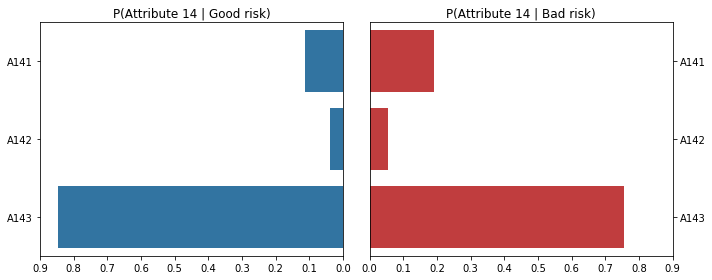

In [64]:
mthelp.plot_table_cond_attr(train_data, "Attribute 14")

Again, this is confirmed by the conditional probabilities below. Those with no installments have a higher chance of being in the good credit set vs. those with bank or store installments.

,A141,A142,A143,All
Credit Risk,,,,
1,57.80%,62.86%,72.26%,69.88%
2,42.20%,37.14%,27.74%,30.12%


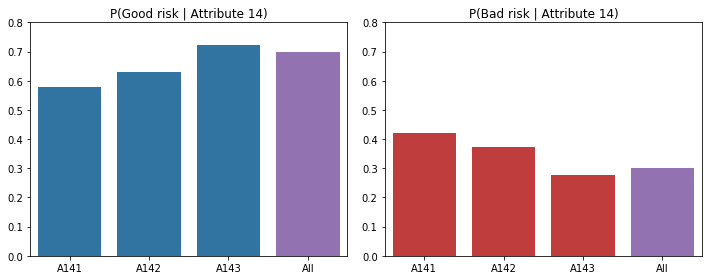

In [65]:
mthelp.plot_prob_attr(train_data, "Attribute 14")

The $\chi^2$-test below confirms that the presence of other installments is not indepedent of credit risk.

In [66]:
mthelp.chi2_test(train_data, "Attribute 14", alpha=0.05)

Chi-square statistic: 10.1382
Critical value: 5.9915
alpha: 0.0500
p-value: 0.0063


However, only the A141 and A143 categories seem to be significantly associated with credit risk according to the individual $\chi^2$-tests. This is explained by the low number of samples under the A142 category.

In [67]:
mthelp.attr_chi2_test(train_data, "Attribute 14")

Attribute 14,A141,A142,A143
Chi-stat,8.0921,0.5432,9.1977
p-values,0.0044,0.4611,0.0024


In [68]:
attr_summary["Attr 14"] = ["Other installment plans", "Categorical", "Significant, chi2-test",
                                "Presence of another installment plan implies lower creditworthiness"]

### <span style="color:blue"> Attribute 15: Housing </span>

This categorical value, which refers to the housing status of the borrower, can take on the following values:
* A151: Renting
* A152: Owned
* A153: Free housing

Similar to the property variable, we expect those who own their places of residences to have better credit risk than those who simply rent.

The graph below shows that most borrowers own their places of residence (72%). Only 11% are under A153 (free housing).

,A151,A152,A153
Attribute 15,18%,72%,11%


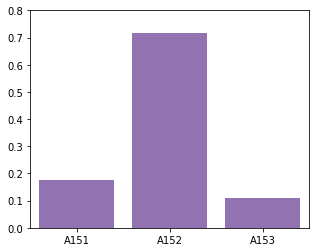

In [69]:
mthelp.plot_table_attr(train_data, "Attribute 15")

The hypothesis is confirmed by the plots below. There are relatively more A152 observations in the good credit risk set vs. the bad credit risk set.

Credit Risk,1,2
Attribute 15,,
A151,14.85%,23.65%
A152,76.39%,60.58%
A153,8.77%,15.77%


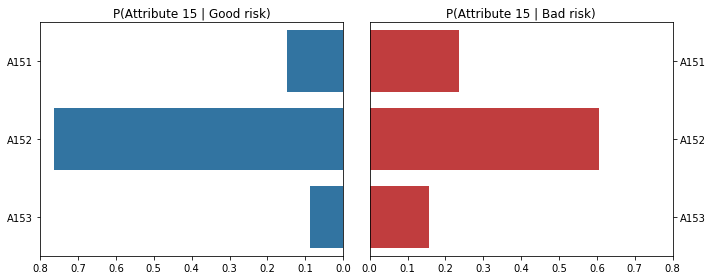

In [70]:
mthelp.plot_table_cond_attr(train_data, "Attribute 15")

Again, the conditional probabilities below confirm the observations and the hypotheses above.

,A151,A152,A153,All
Credit Risk,,,,
1,59.29%,74.52%,56.32%,69.88%
2,40.71%,25.48%,43.68%,30.12%


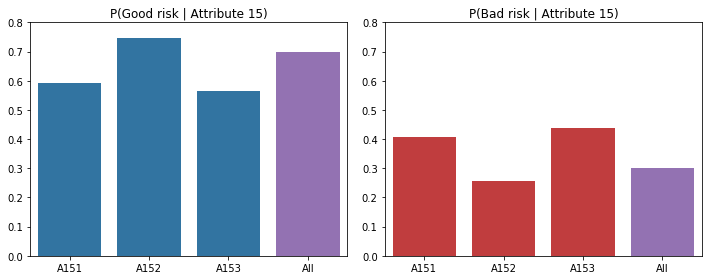

In [71]:
mthelp.plot_prob_attr(train_data, "Attribute 15")

The $\chi^2$-tests below allow us to reject that Attribute 15 and credit risk are independent. Thus, there is significant evidence that suggests that these two variables are related.

In [72]:
mthelp.chi2_test(train_data, "Attribute 15", alpha=0.05)

Chi-square statistic: 20.9232
Critical value: 5.9915
alpha: 0.0500
p-value: 2.86e-05


In [73]:
mthelp.attr_chi2_test(train_data, "Attribute 15")

Attribute 15,A151,A152,A153
Chi-stat,8.4403,19.9289,7.8112
p-values,0.0037,8.04e-06,0.0052


In [74]:
attr_summary["Attr 15"] = ["Housing", "Categorical", "Significant, chi2-test",
                           "Living in owned housing implies higher creditworthiness"]

### <span style="color:blue"> Attribute 17: Nature of job </span>

This is a categorical value with the following possible values:
* A171: Unemployed / unskilled - Non-resident
* A172: Unskilled - Resident
* A173: Skilled employee / official
* A174: Management / self-employed / highly qualified employee / officer

Skilled and managerial positions (A173 and A174) are more commonly associated with higher salaries, compared to unskilled jobs (A171 and A172). Therefore, it is reasonable to hypothesize that A173 and A174 have better credit than A171 and A172.

Most of the borrowers are under the A173 category. Only 2% are unemployed / unskilled non-residents.

,A171,A172,A173,A174
Attribute 17,2%,19%,63%,16%


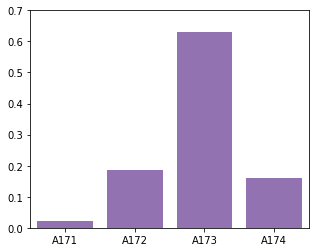

In [75]:
mthelp.plot_table_attr(train_data, "Attribute 17")

The data below does not support the hypothesis stated above. The good credit risk and bad credit risk sets seem to have almost the same distribution of Attribute 17 values.

Credit Risk,1,2
Attribute 17,,
A171,2.15%,2.07%
A172,20.04%,15.77%
A173,62.97%,63.49%
A174,14.85%,18.67%


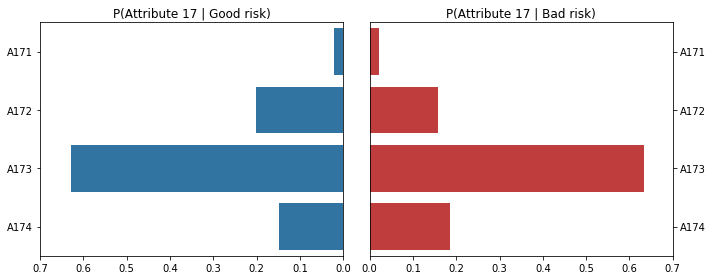

In [76]:
mthelp.plot_table_cond_attr(train_data, "Attribute 17")

Moreover, the conditional probabilities for each possible value of Attribute 17 are very close to the overall good-bad split of the entire training set.

,A171,A172,A173,A174,All
Credit Risk,,,,,
1,70.59%,74.67%,69.70%,64.84%,69.88%
2,29.41%,25.33%,30.30%,35.16%,30.12%


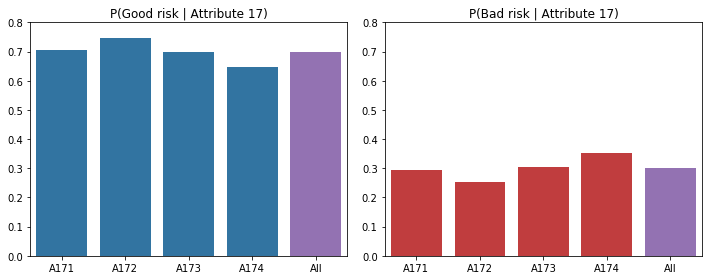

In [77]:
mthelp.plot_prob_attr(train_data, "Attribute 17")

The graphs above suggest that Attribute 17 might not be a good predictor of credit risk. This is supported by the $\chi^2$-test below. According to the results, we cannot reject the hypothesis that Attribute 17 and credit risk are independent.

In [78]:
mthelp.chi2_test(train_data, "Attribute 17", alpha=0.05)

Chi-square statistic: 3.1866
Critical value: 7.8147
alpha: 0.0500
p-value: 0.3637


In [79]:
mthelp.attr_chi2_test(train_data, "Attribute 17")

Attribute 17,A171,A172,A173,A174
Chi-stat,0.0410,1.7433,0.0035,1.5590
p-values,0.8396,0.1867,0.9530,0.2118


In [80]:
attr_summary["Attr 17"] = ["Nature of job", "Categorical", "Not significant, chi2-test", ""]

### <span style="color:blue"> Attribute 19: Telephone </span>

This is essentially a binary variable that tells us if the borrower has a telephone under his/her name or not. This variable has the following possible values:
* A191: None
* A192: Yes, registered under the customer's name

It is reasonable to hypothesize that those who could afford to have a telephone have better credit risk than those who cannot. Thus, we expect relatively more borrowers with telephones in the good credit set vs. the bad credit set.

Most of the borrowers (58%) do not have telephones registered under their name.

,A191,A192
Attribute 19,58%,42%


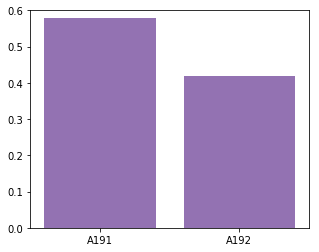

In [81]:
mthelp.plot_table_attr(train_data, "Attribute 19")

As expected, based on the graph below, the proportion of customers with telephones is slightly higher in the good credit set vs. the bad credit set. However, they are very close and the difference might not be statistically significant.

Credit Risk,1,2
Attribute 19,,
A191,57.07%,60.17%
A192,42.93%,39.83%


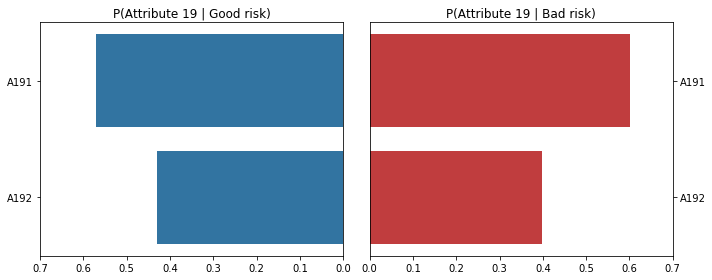

In [82]:
mthelp.plot_table_cond_attr(train_data, "Attribute 19")

The probability of being in the good credit set does not seem to differ significantly between customers with and without telephones.

,A191,A192,All
Credit Risk,,,
1,68.75%,71.43%,69.88%
2,31.25%,28.57%,30.12%


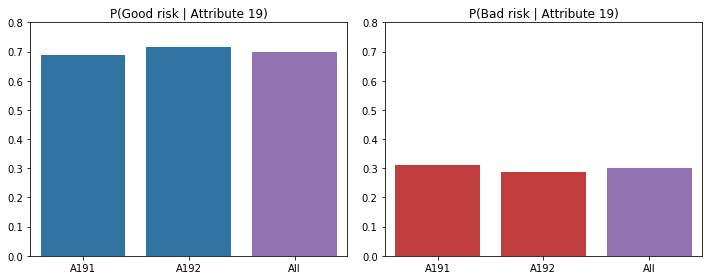

In [83]:
mthelp.plot_prob_attr(train_data, "Attribute 19")

The results above suggest that having a telephone is not a good predictor of credit risk. This is supported by the results of the $\chi^2$-tests below.

In [84]:
mthelp.chi2_test(train_data, "Attribute 19", alpha=0.05)

Chi-square statistic: 0.5431
Critical value: 3.8415
alpha: 0.0500
p-value: 0.4612


In [85]:
mthelp.attr_chi2_test(train_data, "Attribute 19")

Attribute 19,A191,A192
Chi-stat,0.5431,0.5431
p-values,0.4612,0.4612


In [86]:
attr_summary["Attr 19"] = ["Registered telephone", "Categorical", "Not significant, chi2-test", ""]

### <span style="color:blue"> Attribute 20: Foreign / not foreign </span>

This is a binary variable that determines whether the borrower is a foreign worker or not, with the following possible values:
* A201: Yes
* A202: No

Almost all of the borrowers (96%) are non-foreign workers.

,A201,A202
Attribute 20,96%,4%


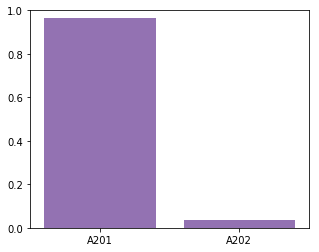

In [87]:
mthelp.plot_table_attr(train_data, "Attribute 20")

There is lower proportion of foreign workers in the bad credit set compared to the good credit set.

Credit Risk,1,2
Attribute 20,,
A201,95.53%,98.76%
A202,4.47%,1.24%


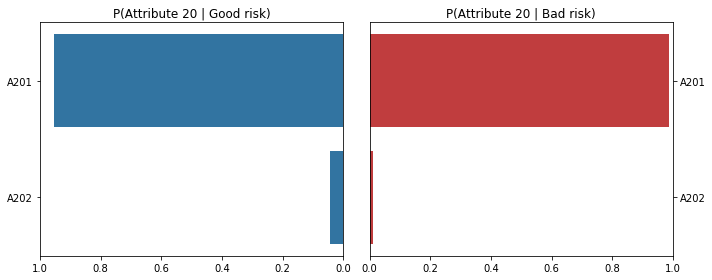

In [88]:
mthelp.plot_table_cond_attr(train_data, "Attribute 20")

The observation above is confirmed by the higher probability of having good risk for foreign workers equal to 89%, compared to only 69% for non-foreign workers.

,A201,A202,All
Credit Risk,,,
1,69.17%,89.29%,69.88%
2,30.83%,10.71%,30.12%


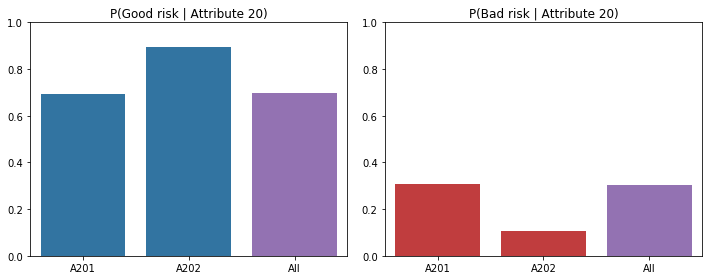

In [89]:
mthelp.plot_prob_attr(train_data, "Attribute 20")

The $\chi^2$-test suggests that knowing that the borrower is a foreigner may affect our assessment of a borrower's credit risk.

In [90]:
mthelp.chi2_test(train_data, "Attribute 20", alpha=0.05)

Chi-square statistic: 4.2819
Critical value: 3.8415
alpha: 0.0500
p-value: 0.0385


In [91]:
mthelp.attr_chi2_test(train_data, "Attribute 20")

Attribute 20,A201,A202
Chi-stat,4.2819,4.2819
p-values,0.0385,0.0385


In [92]:
attr_summary["Attr 20"] = ["Foreign / not foreign", "Categorical", "Significant, chi2-test",
                           "Foreigners have higher probability of having good credit"]

### <span style="color:blue"> Numerical variables </span>

The numerical variables are shown in the heading of the table below. We see that Attributes 8, 11, 16, and 18 only take on very few integral values. Attributes 2, 5, and 13, on the other hand, seem to be continuous numerical variables.

In [93]:
train_data.describe()

,Credit Risk,Attribute 2,Attribute 5,Attribute 8,Attribute 11,Attribute 13,Attribute 16,Attribute 18
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,1.301250,21.095000,3360.618750,2.965000,2.846250,35.558750,1.411250,1.143750
std,0.459088,11.807211,2898.174863,1.122653,1.105277,11.411587,0.578828,0.351056
min,1.000000,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,1.000000,12.000000,1380.000000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,1.000000,18.000000,2333.000000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,2.000000,24.000000,4154.500000,4.000000,4.000000,42.000000,2.000000,1.000000
max,2.000000,60.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


Given the observation above, Attributes 8, 11, 16, and 18 will be first analyzed as categorical variables. Again, this is because the values for these variables are very sparse. Essentially, these numerical variables are bucketized during the data exploration stage.

The other remaining numerical attributes (2, 5, and 13) will be analyzed as true numerical attributes. This will be done by analyzing the attributes' distribution using histograms and boxplots. The t-test will also be used to determine whether the mean value of the the numerical attribute in the good credit set is statistically different from the value of the attribute in the bad credit set.

In [94]:
# Converting the numerical values of Attributes 8, 11, 16, and 18 into categorical values
# that are similar in format to the true categorical variables discussed above
train_data_cat = pd.concat([train_data["Credit Risk"], train_data["Attribute 8"].apply(lambda x: "A8" + str(x)),
                         train_data["Attribute 11"].apply(lambda x: "A11" + str(x)),
                         train_data["Attribute 16"].apply(lambda x: "A16" + str(x)),
                         train_data["Attribute 18"].apply(lambda x: "A18" + str(x))], axis=1)
train_data_cat.head()

,Credit Risk,Attribute 8,Attribute 11,Attribute 16,Attribute 18
29,2,A83,A114,A162,A181
535,2,A82,A111,A161,A181
695,1,A82,A114,A161,A181
557,2,A81,A114,A162,A181
836,1,A84,A112,A161,A181


### <span style="color:blue"> Attribute 8: Installment rate in percentage of disposable income </span>

This numerical variable expresses the borrower's required installment / loan payments as a percentage of his/her disposable income. Again, these numerical values were first 
* A81: Installment payments are 1% of total disposable income
* A82: 2% of disposable income
* A83: 3% of disposable income
* A84: 4% of disposable income

The initial hypothesis for this variable is that bad credit risk borrowers will have their installments as a higher percentage of their disposable income. However, this variable might not be a significant predictor given that the possible values are very close to each other.

Almost half of the borrowers (48%) have installment payments equal to 4% of their disposable income.

,A81,A82,A83,A84
Attribute 8,14%,24%,15%,48%


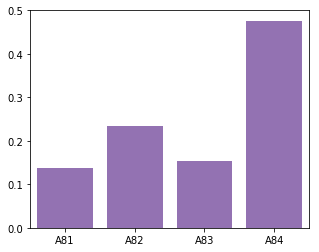

In [95]:
mthelp.plot_table_attr(train_data_cat, "Attribute 8")

Visually, there does not seem to be a significant difference in the distribution of Attribute 8 betwen the good credit risk set and the bad credit risk set.

Credit Risk,1,2
Attribute 8,,
A81,14.31%,12.45%
A82,24.33%,21.58%
A83,15.21%,15.35%
A84,46.15%,50.62%


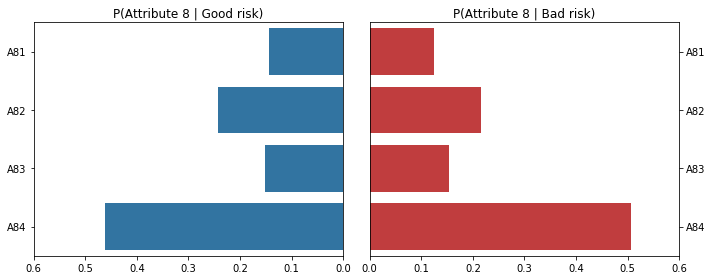

In [96]:
mthelp.plot_table_cond_attr(train_data_cat, "Attribute 8")

Also, the probability of belonging in the good risk seems to decline, albeit only very slightly, as the installment percentage increases.

,A81,A82,A83,A84,All
Credit Risk,,,,,
1,72.73%,72.34%,69.67%,67.89%,69.88%
2,27.27%,27.66%,30.33%,32.11%,30.12%


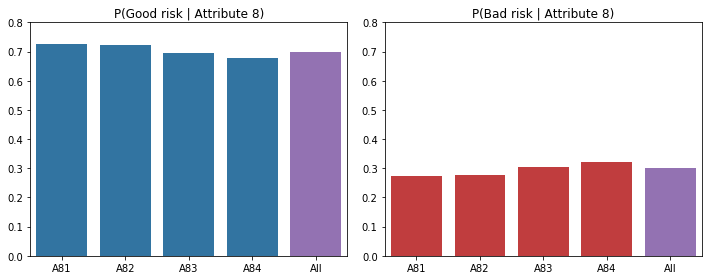

In [97]:
mthelp.plot_prob_attr(train_data_cat, "Attribute 8")

Based on the results of the $\chi^2$-tests below, we fail to reject the null hypothesis that credit risk and Attribute 8 are independent. This suggests that Attribute 8 is not a good predictor for credit risk.

In [98]:
mthelp.chi2_test(train_data_cat, "Attribute 8")

Chi-square statistic: 1.6783
Critical value: 7.8147
alpha: 0.0500
p-value: 0.6418


In [99]:
mthelp.attr_chi2_test(train_data_cat, "Attribute 8")

Attribute 8,A81,A82,A83,A84
Chi-stat,0.3483,0.5648,0.0029,1.1752
p-values,0.5551,0.4523,0.9568,0.2783


In [100]:
attr_summary["Attr 08"] = ["Installment as % of income", "Numerical",
                           "Not significant, chi2-test", "Numerical but converted to categorical"]

### <span style="color:blue"> Attribute 11: Length of time in present residence </span>

This numerical variable expresses the number of years that the borrower has been living in his/her present residence. Again, this was converted into the following categorical variables.
* A111: One year
* A112: Two years
* A113: Three years
* A114: Four years

More than 40% of the borrowers have lived in their present residence for four years. Only 13% have lived in their residence for only one year.

,A111,A112,A113,A114
Attribute 11,13%,31%,15%,42%


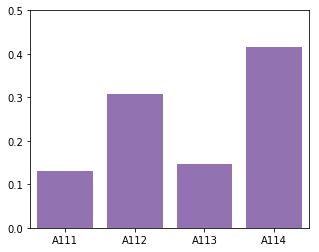

In [101]:
mthelp.plot_table_attr(train_data_cat, "Attribute 11")

Looking at the bar graphs below, there does not seem to be a significant difference in the distribution of Attribute 8 in the good credit risk set vs. the bad credit risk set.

Credit Risk,1,2
Attribute 11,,
A111,13.95%,10.79%
A112,29.70%,33.61%
A113,14.85%,14.11%
A114,41.50%,41.49%


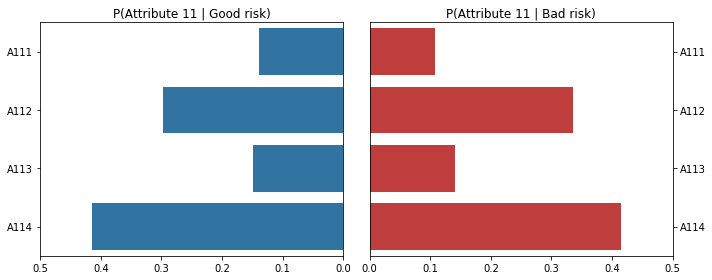

In [102]:
mthelp.plot_table_cond_attr(train_data_cat, "Attribute 11")

Those who have lived in their residence for only one year seem to have a higher probability of belonging in the good risk set compared to other borrowers. However, the difference does not seem to be significant.

,A111,A112,A113,A114,All
Credit Risk,,,,,
1,75.00%,67.21%,70.94%,69.88%,69.88%
2,25.00%,32.79%,29.06%,30.12%,30.12%


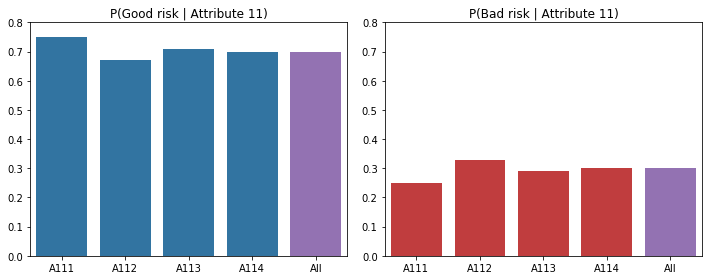

In [103]:
mthelp.plot_prob_attr(train_data_cat, "Attribute 11")

The lack of statistical significance is confirmed by the results of the $\chi^2$-tests below. Therefore, attribute 11 does not seem to be a good predictor of credit risk.

In [104]:
mthelp.chi2_test(train_data_cat, "Attribute 11")

Chi-square statistic: 2.1963
Critical value: 7.8147
alpha: 0.0500
p-value: 0.5327


In [105]:
mthelp.attr_chi2_test(train_data_cat, "Attribute 11")

Attribute 11,A111,A112,A113,A114
Chi-stat,1.2249,1.0324,0.0265,0.0058
p-values,0.2684,0.3096,0.8707,0.9395


In [106]:
attr_summary["Attr 11"] = ["Time in present residence", "Numerical",
                           "Not significant, chi2-test", "Numerical but converted to categorical"]

### <span style="color:blue"> Attribute 16: Number of existing credits at this bank </span>

This numerical variable was converted into a categorical variable with the following values:
* A161: One existing credit at this bank
* A162: Two existing credits
* A163: Three existing credits
* A164: Four existing credits

The initial hypothesis for this variable is the more existing credits the borrower has, the lower his/her creditworthiness is.

Majority (63%) of the borrowers have only one existing credit with the bank. Only 1% have four existing credits.

,A161,A162,A163,A164
Attribute 16,63%,34%,3%,1%


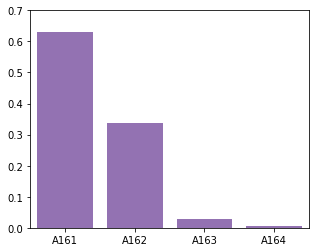

In [107]:
mthelp.plot_table_attr(train_data_cat, "Attribute 16")

The set of observations with bad risk seem to have a relatively higher proportion of borrowers with only one existing credit. This is an evidence contrary to the initial hypothesis. However, the difference between the two proportions does not appear to be significant.

Credit Risk,1,2
Attribute 16,,
A161,61.90%,65.15%
A162,34.35%,32.37%
A163,3.22%,1.66%
A164,0.54%,0.83%


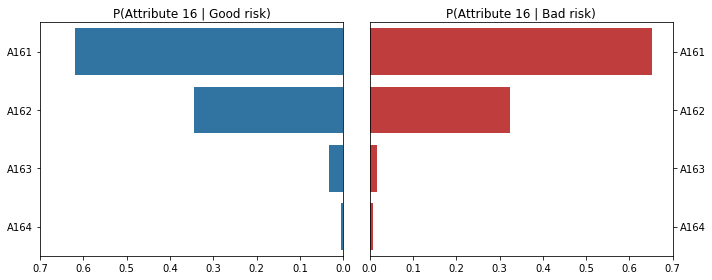

In [108]:
mthelp.plot_table_cond_attr(train_data_cat, "Attribute 16")

Interestingly, those who have three existing credits with the bank have the highest probability of belonging in the good risk set. This suggests that if a relationship between Attribute 16 and credit risk exists, it is not a straightforward linear relationship.

,A161,A162,A163,A164,All
Credit Risk,,,,,
1,68.79%,71.11%,81.82%,60.00%,69.88%
2,31.21%,28.89%,18.18%,40.00%,30.12%


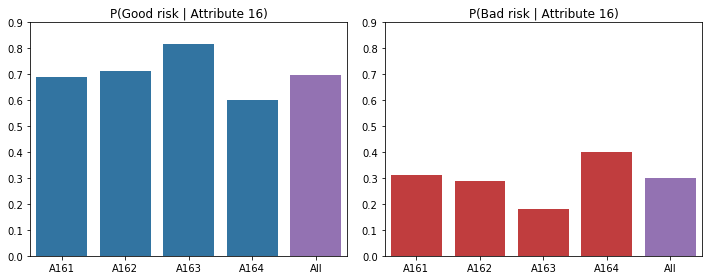

In [109]:
mthelp.plot_prob_attr(train_data_cat, "Attribute 16")

The $\chi^2$-tests below suggest that we cannot reject the null hypothesis that Attribute 16 and credit risk are independent.

In [110]:
mthelp.chi2_test(train_data_cat, "Attribute 16")

Chi-square statistic: 2.2011
Critical value: 7.8147
alpha: 0.0500
p-value: 0.5317


In [111]:
mthelp.attr_chi2_test(train_data_cat, "Attribute 16")

Attribute 16,A161,A162,A163,A164
Chi-stat,0.6287,0.2138,1.0050,3.73e-05
p-values,0.4278,0.6438,0.3161,0.9951


In [112]:
attr_summary["Attr 16"] = ["Number of existing credits", "Numerical",
                           "Not significant, chi2-test", "Numerical but converted to categorical"]

### <span style="color:blue"> Attribute 18: Number of people being liable to provide maintenance for </span>

This numerical variable was converted into a categorical variable with the following values:
* A181: One
* A182: Two

Below is the distribution of the values for this variable in the training set.

,A181,A182
Attribute 18,86%,14%


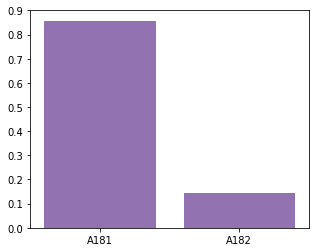

In [113]:
mthelp.plot_table_attr(train_data_cat, "Attribute 18")

The graphs below show the distribution of Attribute 18 in both the good risk set and the bad risk set. We also show below the conditional probability of belonging in the good risk set given the value of Attribute 18. Both graphs suggest that Attribute 18 is not a good predictor for credit risk.

Credit Risk,1,2
Attribute 18,,
A181,85.51%,85.89%
A182,14.49%,14.11%


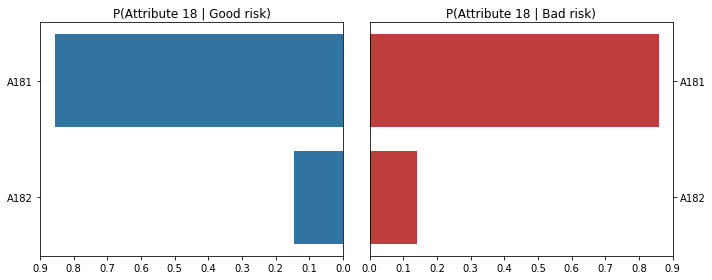

In [114]:
mthelp.plot_table_cond_attr(train_data_cat, "Attribute 18")

,A181,A182,All
Credit Risk,,,
1,69.78%,70.43%,69.88%
2,30.22%,29.57%,30.12%


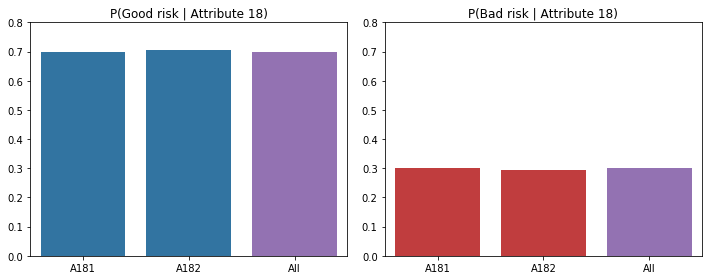

In [115]:
mthelp.plot_prob_attr(train_data_cat, "Attribute 18")

The results of the $\chi^2$-tests below confirm that there does not seem to be an association between Attribute 18 and credit risk.

In [116]:
mthelp.chi2_test(train_data_cat, "Attribute 18")

Chi-square statistic: 0.0010
Critical value: 3.8415
alpha: 0.0500
p-value: 0.9748


In [117]:
mthelp.attr_chi2_test(train_data_cat, "Attribute 18")

Attribute 18,A181,A182
Chi-stat,9.97e-04,9.97e-04
p-values,0.9748,0.9748


In [118]:
attr_summary["Attr 18"] = ["Number of dependents", "Numerical",
                                "Not significant, chi2-test", "Numerical but converted to categorical"]

### <span style="color:blue"> Attribute 2: Duration (in months) </span>

This numerical variable specifies the duration of the loan in months. The table below describes the value of Attribute 2 for the entire training set, for the set of observations with good credit risk, and for the set of observations with bad credit risk. We see that borrowers with good credit risk have a shorter average loan duration than those with bad credit risk.

In [119]:
mthelp.numerical_describe(train_data, "Attribute 2", split=True, total=True)

,Entire set,Good only,Bad only
count,800.000000,559.000000,241.000000
mean,21.095000,19.531306,24.721992
std,11.807211,11.080611,12.639286
min,4.000000,4.000000,6.000000
25%,12.000000,12.000000,14.000000
50%,18.000000,18.000000,24.000000
75%,24.000000,24.000000,36.000000
max,60.000000,60.000000,60.000000


We observe two differently shaped histograms for Attribute 2 in the good credit set and in the bad credit set. We see that the distribution of Attribute 2 in the bad credit risk set has a fatter right tail compared to the distribution in the good credit risk set. This suggests that the probability of being in the bad credit risk set generally increases as the maturity of the loan increases.

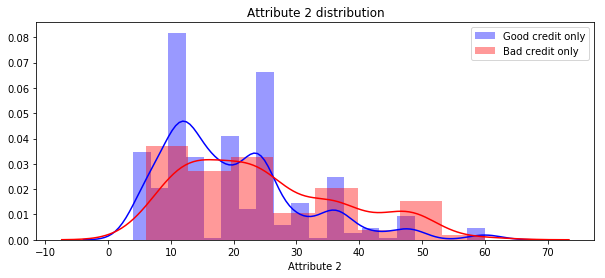

In [120]:
mthelp.numerical_pdf(train_data, "Attribute 2", split=True, total=False)

The boxplots below show that Attribute 2 has a shorter interquartile range and thus, less dispersed in the good credit risk set than in the bad credit risk set.

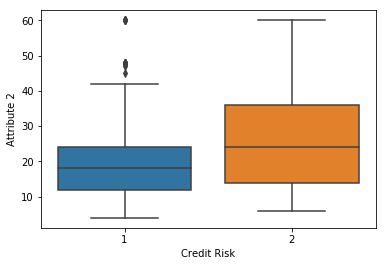

In [121]:
sns.boxplot(y="Attribute 2", x="Credit Risk", data=train_data)

Another statistical test, the independent t-test, was conducted to check whether there is a significant difference between the average loan duration in the good credit set vs. the bad credit set. Below are the hypotheses for this test:
* $H_0$: The mean value of Attribute 2 if Credit Risk = 1 is equal to the mean value of Attribute 2 if Credit Risk = 2.
* $H_a$: The mean value of Attribute 2 if Credit Risk = 1 is not equal to the mean value of Attribute 2 if Credit Risk = 2.

A significant difference between the two means suggest that Attribute 2 could be an indicator of credit risk.

The test below shows a very small p-value, implying that there is a significant difference between the two means.

In [122]:
mthelp.numerical_ttest(train_data, "Attribute 2")

Mean value of Attribute 2 if Credit Risk = 1: 19.53
Mean value of Attribute 2 if Credit Risk = 2: 24.72
t-statistic: -5.8211
p-value: 8.47e-09


In [123]:
attr_summary["Attr 02"] = ["Loan duration", "Numerical", "Significant, t-test",
                           "Good borrowers have shorter loan durations; consider bucketing"]

### <span style="color:blue"> Attribute 5: Credit amount </span>

This numerical variable specifies the value of the loan (in DM). The table below describes the value of Attribute 5 for the entire training set, for the good credit set, and the bad credit set. We observe a higher mean credit amount in the bad credit set.

In [124]:
mthelp.numerical_describe(train_data, "Attribute 5", split=True)

,Entire set,Good only,Bad only
count,800.000000,559.000000,241.000000
mean,3360.618750,3050.166369,4080.713693
std,2898.174863,2480.335223,3593.651467
min,250.000000,250.000000,433.000000
25%,1380.000000,1384.000000,1371.000000
50%,2333.000000,2273.000000,2625.000000
75%,4154.500000,3734.000000,5293.000000
max,18424.000000,15857.000000,18424.000000


Again, we observe two histograms with very different shapes. These show that Attribute 5 in the bad credit set has a fatter right tail than in the good credit set.

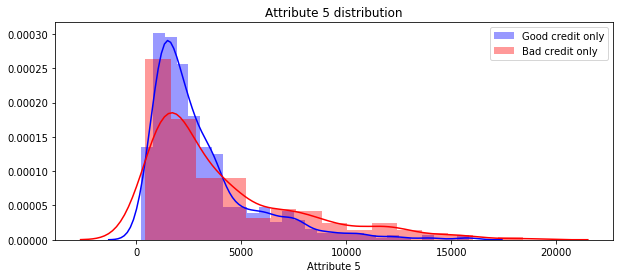

In [125]:
mthelp.numerical_pdf(train_data,"Attribute 5", split=True, total=False)

Our observation above is verified by the box plots below. Moreover, we see that Attribute 2 in the bad credit set has a higher level of dispersion than in the good credit set.

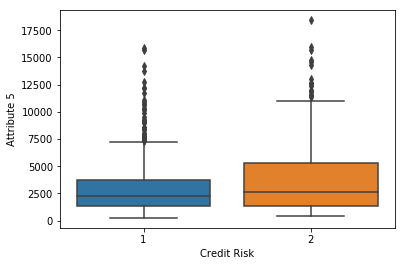

In [126]:
sns.boxplot(y="Attribute 5", x="Credit Risk", data=train_data)

The t-test below shows that there is a significant difference between the mean value of Attribute 5 in the good credit set is significantly different from the mean value in the bad credit set.

In [127]:
mthelp.numerical_ttest(train_data, "Attribute 5")

Mean value of Attribute 5 if Credit Risk = 1: 3050.17
Mean value of Attribute 5 if Credit Risk = 2: 4080.71
t-statistic: -4.6742
p-value: 3.46e-06


In [128]:
attr_summary["Attr 05"] = ["Loan amount", "Numerical", "Significant, t-test",
                           "Good borrowers have lower loan amounts; consider bucketing"]

### <span style="color:blue"> Attribute 13: Age (in years) </span>

This numerical variable specifies the age of the borrower. The table below describes the value of Attribute 13 for the entire training set, for the good credit set, and the bad credit set. We observe a higher mean age for observations in the good credit set.

In [129]:
mthelp.numerical_describe(train_data, "Attribute 13", split=True, total=True)

,Entire set,Good only,Bad only
count,800.000000,559.000000,241.000000
mean,35.558750,36.599284,33.145228
std,11.411587,11.576939,10.656359
min,19.000000,19.000000,19.000000
25%,27.000000,27.000000,25.000000
50%,33.000000,35.000000,30.000000
75%,42.000000,43.000000,39.000000
max,75.000000,75.000000,74.000000


The historgrams below show that the distribution of Attribute 13 in the good credit set is different from the distribution of the attribute in the bad credit set. We observe a fatter right tail in the good credit set.

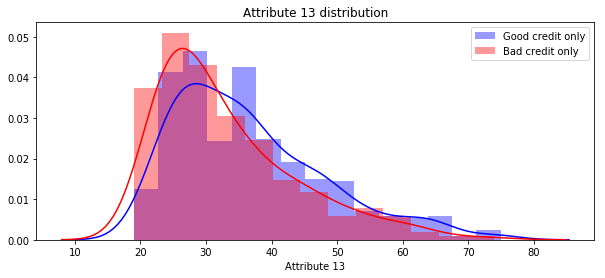

In [130]:
mthelp.numerical_pdf(train_data, "Attribute 13", split=True, total=False)

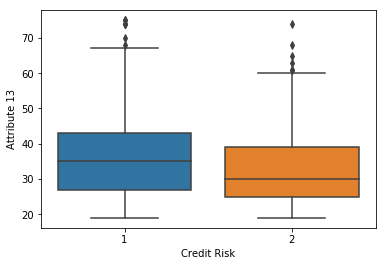

In [131]:
sns.boxplot(y="Attribute 13", x="Credit Risk", data=train_data)

The t-test below shows that there is a significant difference between the ages in the good credit set and in the bad credit set.

In [132]:
mthelp.numerical_ttest(train_data, "Attribute 13")

Mean value of Attribute 13 if Credit Risk = 1: 36.60
Mean value of Attribute 13 if Credit Risk = 2: 33.15
t-statistic: 3.9638
p-value: 8.04e-05


In [133]:
attr_summary["Attr 13"] = ["Age", "Numerical", "Significant, t-test", "Good borrowers tend to be older; consider bucketing"]

### <span style="color:blue"> Summary </span>

Below is a summary of the insights gathered from the data exploration above.

In [134]:
summary_df = pd.DataFrame(attr_summary, index=["Description", "Nature",
                                               "Significance and test used", "Other notes"]).transpose().sort_index()
pd.options.display.max_colwidth = 100
display(summary_df)

,Description,Nature,Significance and test used,Other notes
Attr 01,Checking account,Categorical,"Significant, chi2-test","Higher account balance, better credit"
Attr 02,Loan duration,Numerical,"Significant, t-test",Good borrowers have shorter loan durations; consider bucketing
Attr 03,Credit history,Categorical,"Significant, chi2-test","Better to focus on following values: A30, A31, A34"
Attr 04,Purpose,Categorical,"Significant, chi2-test","Better to focus on following values: A40, A41, A43, A46"
Attr 05,Loan amount,Numerical,"Significant, t-test",Good borrowers have lower loan amounts; consider bucketing
Attr 06,Savings account / bonds,Categorical,"Significant, chi2-test","Higher savings / bond value, better credit"
Attr 07,Time in present employment,Categorical,"Significant, chi2-test","Better to create fewer categories: (1) A71 and A72, (2) A73 and A74, and (3) A75"
Attr 08,Installment as % of income,Numerical,"Not significant, chi2-test",Numerical but converted to categorical
Attr 09,Sex and marital status,Categorical,"Significant, chi2-test",
Attr 10,Other debtors / guarantors,Categorical,"Not significant, chi2-test",


## <span style="color:blue"> Preparing the models </span>

### <span style="color:blue"> Baseline model </span>

Since a significant majority (70%) of the observations are assigned a good credit, the baseline model that will be used is to simply assign good credit to all observations. Essentially, this is a dummy classifier that assigns the most frequent value.

In [135]:
y_pred_baseline = np.ones(train_data["Credit Risk"].shape)
acc_baseline = accuracy_score(y_train, y_pred_baseline)
print("Baseline accuracy: {:.2%}".format(acc_baseline))

Baseline accuracy: 69.88%


Obviously, this model does a good job of predicting good credit customers but a really bad job of identifying those with bad credit.

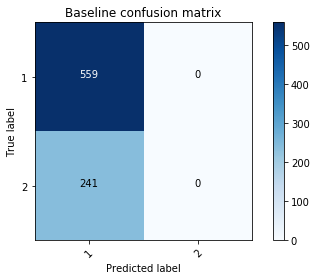

In [136]:
conf_baseline = confusion_matrix(y_true = y_train, y_pred = y_pred_baseline)
mthelp.plot_confusion_matrix(conf_baseline, classes=[1,2], title="Baseline confusion matrix")

In [137]:
print(classification_report(y_train, y_pred_baseline, target_names=["Good", "Bad"], digits=4))

              precision    recall  f1-score   support

        Good     0.6987    1.0000    0.8227       559
         Bad     0.0000    0.0000    0.0000       241

   micro avg     0.6987    0.6987    0.6987       800
   macro avg     0.3494    0.5000    0.4113       800
weighted avg     0.4883    0.6987    0.5748       800



### <span style="color:blue"> Gaussian Naive Bayes </span>

This model is more sophisticated than the dummy classifier but is still relatively simple, making it a good choice for another baseline model. For this step, the results of the data exploration stage will first be ignored. Unlike in the data exploration stage, Attributes 8, 11, 16, and 18 will be considered numerical. Categorical variables will be transformed into binary variables using one-hot encoding.

In [138]:
num_attrs = [2, 5, 8, 11, 13, 16, 18]
cat_attrs = [1, 3, 4, 6, 7, 9, 10, 12, 14, 15, 17, 19, 20]

num_pip_1 = Pipeline([
            ("select_numeric", mthelp.ColumnSelector( ["Attribute " + str(x) for x in num_attrs] ))
            ])
cat_pip_1 = Pipeline([
            ("select_categorical", mthelp.ColumnSelector( ["Attribute " + str(x) for x in cat_attrs] )),
            ("ohe", mthelp.DataFrameOHE())
            ])
pre_pip_1 = mthelp.PandasFeatureUnion(transformer_list=[
            ("numeric", num_pip_1),
            ("categorical", cat_pip_1)
            ])

In [139]:
X_train_1 = pre_pip_1.fit_transform(train_data)
X_train_1.head()

,Attribute 2,Attribute 5,Attribute 8,Attribute 11,Attribute 13,Attribute 16,Attribute 18,Attribute 1_A11,Attribute 1_A12,Attribute 1_A13,...,Attribute 15_A152,Attribute 15_A153,Attribute 17_A171,Attribute 17_A172,Attribute 17_A173,Attribute 17_A174,Attribute 19_A191,Attribute 19_A192,Attribute 20_A201,Attribute 20_A202
29,60,6836,3,4,63,2,1,1,0,0,...,1,0,0,0,1,0,0,1,1,0
535,21,2319,2,1,33,1,1,0,0,1,...,0,0,0,0,1,0,1,0,1,0
695,6,1236,2,4,50,1,1,0,0,0,...,0,0,0,0,1,0,1,0,1,0
557,21,5003,1,4,29,2,1,0,0,0,...,1,0,0,0,1,0,0,1,1,0
836,12,886,4,2,21,1,1,0,0,0,...,1,0,0,0,1,0,1,0,1,0


In [140]:
nb = GaussianNB()
nb.fit(X_train_1, y_train)
y_pred_nb = nb.predict(X_train_1)

After one-hot encoding all categorical variables, the data set now has 61 different features.

The results of the Naive Bayes model is only marginally higher compared to the baseline model.

In [141]:
cv_acc_nb = cross_val_score(nb, X=X_train_1, y=y_train, cv=10, scoring="accuracy")
acc_nb = cv_acc_nb.mean()
print(cv_acc_nb)
print("Baseline model accuracy: {:0.2%}".format(acc_baseline))
print("Naive Bayes accuracy: {:0.2%}".format(acc_nb))

[0.7654321  0.8        0.7125     0.65       0.6125     0.6375
 0.7        0.8        0.7125     0.60759494]
Baseline model accuracy: 69.88%
Naive Bayes accuracy: 69.98%


However, when we look at the confusion matrix below, it does a better job of being able to identify bad credit observations, which the dummy classifier is not able to do at all. In other words, when we focus at the bad credit observations, the Naive Bayes model has better recall and precision.

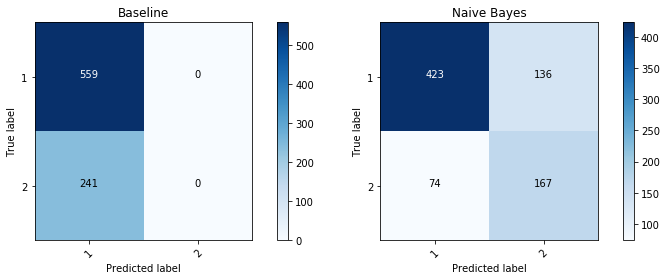

In [142]:
conf_nb = confusion_matrix(y_true = y_train, y_pred = y_pred_nb)
mthelp.plot_confs(conf_baseline, conf_nb, title1="Baseline", title2="Naive Bayes")

In [143]:
print(classification_report(y_train, y_pred_nb, target_names=["Good", "Bad"], digits=4))

              precision    recall  f1-score   support

        Good     0.8511    0.7567    0.8011       559
         Bad     0.5512    0.6929    0.6140       241

   micro avg     0.7375    0.7375    0.7375       800
   macro avg     0.7011    0.7248    0.7076       800
weighted avg     0.7607    0.7375    0.7448       800



### <span style="color:blue"> Logistic trial 1: Using all variables with no transformations </span>

The logistic regression model is more sophisticated than the Naive Bayes but is still a relatively simple classification model.

Similar to the Naive Bayes, the results of the data exploration stage and all variables will be included in the model in order to better compare the performance of the logistic model vs. the naive Bayes model. Essentially, it will use the same training data from the previous model.

In [144]:
log1 = LogisticRegression(solver="liblinear")
log1.fit(X_train_1, y_train)
y_pred_log1 = log1.predict(X_train_1)

The logistic regression model with raw features peformed better than the naive Bayes in terms of accuracy.

In [145]:
cv_acc_log1 = cross_val_score(log1, X=X_train_1, y=y_train, cv=10, scoring="accuracy")
acc_log1 = cv_acc_log1.mean()
print(cv_acc_log1)
print("Naive Bayes accuracy: {:0.2%}".format(acc_nb))
print("Logistic model (trial 1) accuracy: {:0.2%}".format(acc_log1))

[0.7037037  0.8125     0.75       0.7125     0.6875     0.675
 0.8125     0.8125     0.7125     0.72151899]
Naive Bayes accuracy: 69.98%
Logistic model (trial 1) accuracy: 74.00%


However, the logistic model performed worse in identifying the bad credit borrowers. It showed an increase in the number of bad credit borrowers that are misclassified as good credit.

The key improvement in the model comes from its ability to predict mode correct bad credit risk borrowers. However, its ability to correctly predict good credit risk borrowers suffered.

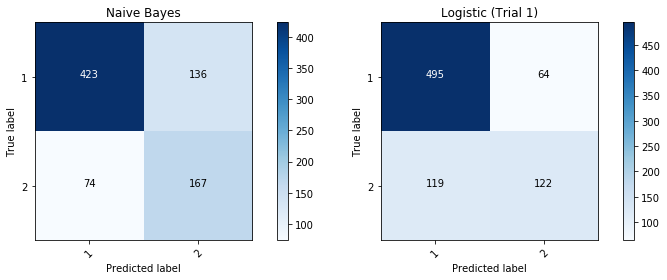

In [146]:
conf_log1 = confusion_matrix(y_true = y_train, y_pred = y_pred_log1)
mthelp.plot_confs(conf_nb, conf_log1, title1="Naive Bayes", title2="Logistic (Trial 1)")

In [147]:
print(classification_report(y_train, y_pred_log1, target_names=["Good", "Bad"], digits=4))

              precision    recall  f1-score   support

        Good     0.8062    0.8855    0.8440       559
         Bad     0.6559    0.5062    0.5714       241

   micro avg     0.7712    0.7712    0.7712       800
   macro avg     0.7311    0.6959    0.7077       800
weighted avg     0.7609    0.7712    0.7619       800



### <span style="color:blue"> Logistic trial 2: Remove non-significant variables </span>

The next attempt will remove the variables that were deemed non-significant predictors in the data exploration stage. No other feature engineering will be attempted for the other variables.

In [148]:
num_attrs = [2, 5, 13]
cat_attrs = [1, 3, 4, 6, 7, 9, 12, 14, 15, 20]

num_pip_2 = Pipeline([
            ("select_numeric", mthelp.ColumnSelector( ["Attribute " + str(x) for x in num_attrs] ))
            ])
cat_pip_2 = Pipeline([
            ("select_categorical", mthelp.ColumnSelector( ["Attribute " + str(x) for x in cat_attrs] )),
            ("ohe", mthelp.DataFrameOHE())
            ])
pre_pip_2 = mthelp.PandasFeatureUnion(transformer_list=[
            ("numeric", num_pip_2),
            ("categorical", cat_pip_2)
            ])

Dropping some attributes reduces the number of features from 61 to 48.

In [149]:
X_train_2 = pre_pip_2.fit_transform(train_data)
X_train_2.head()

,Attribute 2,Attribute 5,Attribute 13,Attribute 1_A11,Attribute 1_A12,Attribute 1_A13,Attribute 1_A14,Attribute 3_A30,Attribute 3_A31,Attribute 3_A32,...,Attribute 12_A123,Attribute 12_A124,Attribute 14_A141,Attribute 14_A142,Attribute 14_A143,Attribute 15_A151,Attribute 15_A152,Attribute 15_A153,Attribute 20_A201,Attribute 20_A202
29,60,6836,63,1,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,1,0
535,21,2319,33,0,0,1,0,0,0,0,...,1,0,0,0,1,1,0,0,1,0
695,6,1236,50,0,0,0,1,0,0,1,...,0,0,0,0,1,1,0,0,1,0
557,21,5003,29,0,0,0,1,1,0,0,...,0,0,1,0,0,0,1,0,1,0
836,12,886,21,0,0,0,1,0,0,1,...,1,0,0,0,1,0,1,0,1,0


In [150]:
log2 = LogisticRegression(solver="liblinear")
log2.fit(X_train_2, y_train)
y_pred_log2 = log2.predict(X_train_2)

The accuracy score produced form a ten-fold cross validation shows a very small improvement.

In [151]:
cv_acc_log2 = cross_val_score(log2, X=X_train_2, y=y_train, cv=10, scoring="accuracy")
acc_log2 = cv_acc_log2.mean()
print(cv_acc_log2)
print("Logistic model (Trial 1) accuracy: {:0.2%}".format(acc_log1))
print("Logistic model (Trial 2) accuracy: {:0.2%}".format(acc_log2))

[0.71604938 0.8375     0.75       0.7        0.65       0.675
 0.8125     0.8125     0.75       0.78481013]
Logistic model (Trial 1) accuracy: 74.00%
Logistic model (Trial 2) accuracy: 74.88%


Although the second trial showed marginal improvement in correctly predicting good credit borrowers, its ability to identify bad credit borrowers worsened.

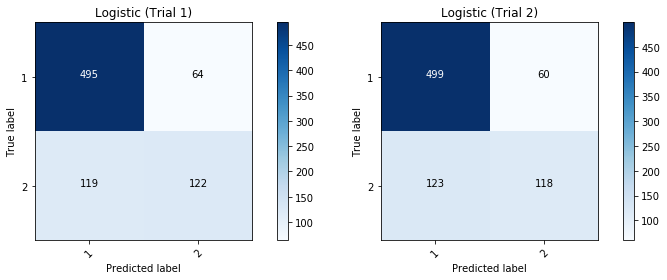

In [152]:
conf_log2 = confusion_matrix(y_true = y_train, y_pred = y_pred_log2)
mthelp.plot_confs(conf_log1, conf_log2, title1="Logistic (Trial 1)", title2="Logistic (Trial 2)")

In [153]:
print(classification_report(y_train, y_pred_log2, target_names=["Good", "Bad"], digits=4))

              precision    recall  f1-score   support

        Good     0.8023    0.8927    0.8450       559
         Bad     0.6629    0.4896    0.5632       241

   micro avg     0.7712    0.7712    0.7712       800
   macro avg     0.7326    0.6911    0.7041       800
weighted avg     0.7603    0.7712    0.7602       800



The key insight from this result is that even though model performance did not improve when certain attributes were dropped, performance did not significantly decline either. This confirms the results of the $\chi^2$-tests, which imply that these dropped attributes indeed are not good predictors.

### <span style="color:blue"> Logistic trial 3: Remove unimportant features and feature values </span>

The next attempt will remove that non-important values in certain features. For instance, in Attribute 3 (Purpose), some values unimportant values will be merged together into one category (Oth, for Other). The significant values, on the other hand, will retain their original values. Similar transformations was also done in Attribute 4, 7, and 12.

In [154]:
maps = { "Attribute 3":{"A30":"A30", "A31":"A31", "A32":"Oth", "A33":"Oth", "A34":"A34"},
         "Attribute 4":{"A40":"A40", "A41":"A41", "A42":"Oth", "A43":"A43", "A44":"Oth", "A45":"Oth",
                         "A46":"A46", "A47":"Oth", "A48":"Oth", "A49":"Oth"},
         "Attribute 12":{"A121":"A121", "A122":"Oth", "A123":"Oth", "A124":"Oth"},
         "Attribute 7":{"A71":"B1", "A72":"B1", "A73":"B2", "A74":"B2", "A75":"B3"}
       }

num_attrs = [2, 5, 13]
cat_attrs = [1, 3, 4, 6, 7, 9, 12, 14, 15, 20]

cat_pip_3 = Pipeline([
            ("select_categorical", mthelp.ColumnSelector( ["Attribute " + str(x) for x in cat_attrs] )),
            ("change_vals", mthelp.ChangeVals( celkeyvaldict = maps )),
            ("ohe", mthelp.DataFrameOHE())
            ])
num_pip_3 = num_pip_2
pre_pip_3 = mthelp.PandasFeatureUnion(transformer_list=[
            ("numeric", num_pip_3),
            ("categorical", cat_pip_3)
            ])

In [155]:
X_train_3 = pre_pip_3.fit_transform(train_data)
X_train_3.head()

,Attribute 2,Attribute 5,Attribute 13,Attribute 1_A11,Attribute 1_A12,Attribute 1_A13,Attribute 1_A14,Attribute 3_A30,Attribute 3_A31,Attribute 3_A34,...,Attribute 12_A121,Attribute 12_Oth,Attribute 14_A141,Attribute 14_A142,Attribute 14_A143,Attribute 15_A151,Attribute 15_A152,Attribute 15_A153,Attribute 20_A201,Attribute 20_A202
29,60,6836,63,1,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,1,0
535,21,2319,33,0,0,1,0,0,0,1,...,0,1,0,0,1,1,0,0,1,0
695,6,1236,50,0,0,0,1,0,0,0,...,0,1,0,0,1,1,0,0,1,0
557,21,5003,29,0,0,0,1,1,0,0,...,0,1,1,0,0,0,1,0,1,0
836,12,886,21,0,0,0,1,0,0,0,...,0,1,0,0,1,0,1,0,1,0


In [156]:
log3 = LogisticRegression(solver="liblinear")
log3.fit(X_train_3, y_train)
y_pred_log3 = log3.predict(X_train_3)

After this new round of feature engineering, accuracy improved slightly compared to the previous model.

In [157]:
cv_acc_log3 = cross_val_score(log3, X=X_train_3, y=y_train, cv=10, scoring="accuracy")
acc_log3 = cv_acc_log3.mean()
print(cv_acc_log3)
print("Logistic model (Trial 2) accuracy: {:0.2%}".format(acc_log2))
print("Logistic model (Trial 3) accuracy: {:0.2%}".format(acc_log3))

[0.7654321  0.8375     0.775      0.675      0.7        0.6875
 0.775      0.8125     0.725      0.79746835]
Logistic model (Trial 2) accuracy: 74.88%
Logistic model (Trial 3) accuracy: 75.50%


However, when looking at the confusion matrix, the forecast for good credit improved slightly but was offset by an equal decline in the forecast for bad credit.

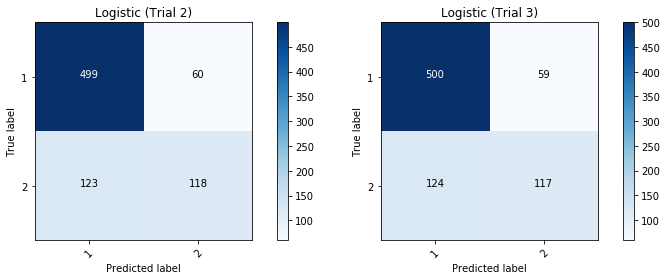

In [158]:
conf_log3 = confusion_matrix(y_true = y_train, y_pred = y_pred_log3)
mthelp.plot_confs(conf_log2, conf_log3, title1="Logistic (Trial 2)", title2="Logistic (Trial 3)")

In [159]:
print(classification_report(y_train, y_pred_log3, target_names=["Good", "Bad"], digits=4))

              precision    recall  f1-score   support

        Good     0.8013    0.8945    0.8453       559
         Bad     0.6648    0.4855    0.5612       241

   micro avg     0.7712    0.7712    0.7712       800
   macro avg     0.7330    0.6900    0.7032       800
weighted avg     0.7602    0.7712    0.7597       800



Again, the above confirms the results of the statistical tests done on the data. Removing certain values of these variables reduced the information availeble but did not necessarily eliminate predictive power from the model. This is because the values removed were deemed to be not very good indicators for credit risk. In fact, it even showed a slight improvement in accuracy, computed using ten-fold cross validation. Perhaps this is because it removes unnecessary noise from the data set.

### <span style="color:blue"> Decision tree trial 1: Using all variables with no transformations </span>

This attempt will use the same training set as the first trial of the logistic regression model, which uses all the variables and values in the original data set, even the ones deemed insignificant.

In [160]:
dt1 = DecisionTreeClassifier(random_state=42)
dt1.fit(X_train_1, y_train)
y_pred_dt1 = dt1.predict(X_train_1)

The results below show that without any feature engineering, the decision tree classifier performed worse than not only  logistic regression but also the baseline model. Again, in this scenario, performance is measured using the accuracy score with ten-fold cross validation.

In [161]:
cv_acc_dt1 = cross_val_score(dt1, X=X_train_1, y=y_train, cv=10, scoring="accuracy")
acc_dt1 = cv_acc_dt1.mean()
print(cv_acc_dt1)
print("Logistic model (Trial 3) accuracy: {:0.2%}".format(acc_log3))
print("Decision tree (Trial 1) accuracy: {:0.2%}".format(acc_dt1))

[0.65432099 0.675      0.7        0.675      0.575      0.675
 0.65       0.675      0.625      0.70886076]
Logistic model (Trial 3) accuracy: 75.50%
Decision tree (Trial 1) accuracy: 66.13%


If we look at the confusion matrix, we observe that the model was able to perfectly predict the entire training set. However, the accuracy computed above only 66.13%. This is because the accuracy was computed using ten-fold cross validation. The perfect confusion matrix and a very low accuracy from cross validation is a very good indication that the model is overfitting the data. Essentially, the model simply memorized the training set.

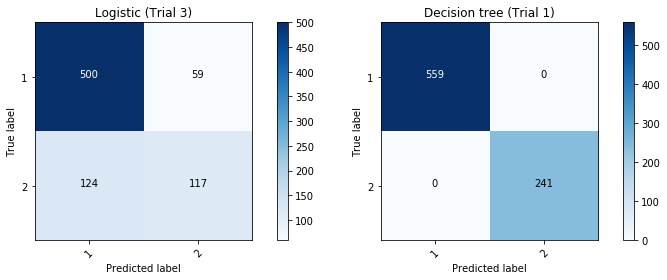

In [162]:
conf_dt1 = confusion_matrix(y_true = y_train, y_pred = y_pred_dt1)
mthelp.plot_confs(conf_log3, conf_dt1, title1="Logistic (Trial 3)", title2="Decision tree (Trial 1)")

### <span style="color:blue"> Decision tree trial 2: Using all variable with no transformation but optimizing model parameters </span>

The next attempt will remove the variables that were deemed non-significant predictors in the data exploration stage. No other feature engineering will be attempted for the other variables.

In the previous trial, the default values for the parameters were used. In this trial, the same training set will be used but a grid search will be used to optimize certain model parameters, specifically `max_depth` and `min_samples_leaf`.

Below are the possible values for `max_depth` that `GridSearchCV` will go over. I believe that choosing an upper bound of 40 should be enough. In reality, a lower value would probably suffice because a very high `max_depth` would increase the chance of overfitting.

In [163]:
depths = np.arange(1, 41)
depths

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40])

Below are the possible values for `min_samples_leaf` that will be used in the grid search.

In [164]:
num_leafs = np.arange(1,51)
num_leafs

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [165]:
param_grid = [{'max_depth':depths, 'min_samples_leaf':num_leafs}]

In [166]:
dt2 = DecisionTreeClassifier(random_state=42)
gs1 = GridSearchCV(estimator=dt2, param_grid=param_grid, scoring="accuracy", cv=10, iid=True)

In [167]:
gs1.fit(X_train_1, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=None,
       param_grid=[{'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40]), 'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
  

According to the grid search, the optimal `max_depth` is 10 while the optimal `min_samples_leaf` is 15. These give a best accuracy score (under a ten-fold cross validation) equal to 72%, still worse than logistic regression.

In [168]:
gs1.best_params_

{'max_depth': 10, 'min_samples_leaf': 15}

In [169]:
print("{:.2%}".format(gs1.best_score_))

72.00%


In [170]:
dt2 = gs1.best_estimator_
dt2.fit(X_train_1, y_train)
y_pred_dt2 = dt2.predict(X_train_1)

In [171]:
cv_acc_dt2 = cross_val_score(dt2, X=X_train_1, y=y_train, cv=10, scoring="accuracy")
acc_dt2 = cv_acc_dt2.mean()
print(cv_acc_dt2)
print("Logistic model (Trial 3) accuracy: {:0.2%}".format(acc_log3))
print("Decision tree (Trial 2) accuracy: {:0.2%}".format(acc_dt2))

[0.66666667 0.725      0.6625     0.725      0.6625     0.7625
 0.7375     0.75       0.75       0.75949367]
Logistic model (Trial 3) accuracy: 75.50%
Decision tree (Trial 2) accuracy: 72.01%


The results below suggest that the decision tree model is again overfitting and simply memorizing the data. This is evidenced by the better confusion matrix and classification metrics, which were computed without cross validation. Using a ten-fold validation, however, the model gives an accuracy of 72%, higher than the accuracy given by the unoptimized decision tree model.

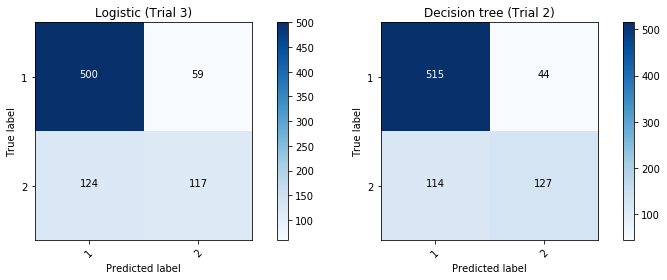

In [172]:
conf_dt2 = confusion_matrix(y_true = y_train, y_pred = y_pred_dt2)
mthelp.plot_confs(conf_log3, conf_dt2, title1="Logistic (Trial 3)", title2="Decision tree (Trial 2)")

In [173]:
print(classification_report(y_train, y_pred_dt2, target_names=["Good", "Bad"], digits=4))

              precision    recall  f1-score   support

        Good     0.8188    0.9213    0.8670       559
         Bad     0.7427    0.5270    0.6165       241

   micro avg     0.8025    0.8025    0.8025       800
   macro avg     0.7807    0.7241    0.7418       800
weighted avg     0.7958    0.8025    0.7915       800



### <span style="color:blue"> Decision tree trial 3: Remove unimportant features and feature values </span>

The third attempt for the decision tree classifier will again use `GridSearchCV` to optimize `max_depth` and `min_samples_leaf` by looking at the optimal pair of parameters that will yield the best accuracy score from a ten-fold cross validation. The same set of depths and sample sizes used in Trial 2 will be used.

For this attempt, however, the training data will exclude the unimportant features and values. This is the same training data used in Trial 3 for logistic regression.

In [174]:
dt3 = DecisionTreeClassifier(random_state=42)
gs2 = GridSearchCV(estimator=dt3, param_grid=param_grid, scoring="accuracy", cv=10, iid=True)

In [175]:
gs2.fit(X_train_3, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=None,
       param_grid=[{'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40]), 'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
  

This attempt gave the same `max_depth` as the previous model but a smaller `min_samples_leaf` size of 11. It yielded a marginally higher accuracy score, again based on ten-fold cross validation, equal to 72.5%, compared to the 72% from the previous model.

In [176]:
gs2.best_params_

{'max_depth': 10, 'min_samples_leaf': 11}

In [177]:
print("{:.2%}".format(gs2.best_score_))

72.50%


In [178]:
dt3 = gs2.best_estimator_
dt3.fit(X_train_3, y_train)
y_pred_dt3 = dt3.predict(X_train_3)

Just like the previous iteration, this model suffers from overfitting, as evidenced by the significant difference between the accuracy score without cross validation (81%) vs. the accuracy score with ten-fold cross validation (73%). Using this metric, this model performs worse than the third trial of the logistic regression model.

In [179]:
cv_acc_dt3 = cross_val_score(dt3, X=X_train_3, y=y_train, cv=10, scoring="accuracy")
acc_dt3 = cv_acc_dt3.mean()
print(cv_acc_dt3)
print("Logistic model (Trial 3) accuracy: {:0.2%}".format(acc_log3))
print("Decision tree (Trial 3) accuracy: {:0.2%}".format(acc_dt3))

[0.71604938 0.775      0.7625     0.7        0.65       0.7125
 0.7375     0.7125     0.725      0.75949367]
Logistic model (Trial 3) accuracy: 75.50%
Decision tree (Trial 3) accuracy: 72.51%


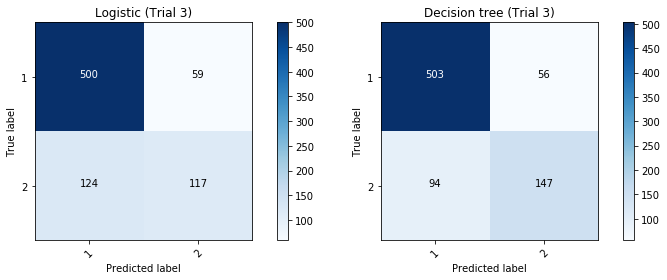

In [180]:
conf_dt3 = confusion_matrix(y_true = y_train, y_pred = y_pred_dt3)
mthelp.plot_confs(conf_log3, conf_dt3, title1="Logistic (Trial 3)", title2="Decision tree (Trial 3)")

In [181]:
print(classification_report(y_train, y_pred_dt3, target_names=["Good", "Bad"], digits=4))

              precision    recall  f1-score   support

        Good     0.8425    0.8998    0.8702       559
         Bad     0.7241    0.6100    0.6622       241

   micro avg     0.8125    0.8125    0.8125       800
   macro avg     0.7833    0.7549    0.7662       800
weighted avg     0.8069    0.8125    0.8076       800



### <span style="color:blue"> Side quest: Discretizing the numerical attributes </span>

This trial will attempt to use decision tree to convert numerical values into bins using decision tree classifier. Per usual, the grid search is used to optimize the parameters of the decision tree under ten-fold cross validation.

In [182]:
num_attrs = ["Attribute 2", "Attribute 5", "Attribute 13"]
X_num_only = train_data[num_attrs]
X_num_only.head()

,Attribute 2,Attribute 5,Attribute 13
29,60,6836,63
535,21,2319,33
695,6,1236,50
557,21,5003,29
836,12,886,21


In [183]:
dtforbins = DecisionTreeClassifier(random_state=42)
gs3 = GridSearchCV(estimator=dtforbins, param_grid=param_grid, scoring="accuracy", cv=10, iid=True)

In [184]:
gs3.fit(X_num_only, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=None,
       param_grid=[{'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40]), 'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
  

In [185]:
gs3.best_params_

{'max_depth': 4, 'min_samples_leaf': 1}

In [186]:
dtforbins = gs3.best_estimator_

Below is the result of the optimized decision tree classifier. Note that each node in the graph contains a partition of each continuous variable. These partitions will be used as the boundaries for the buckets.

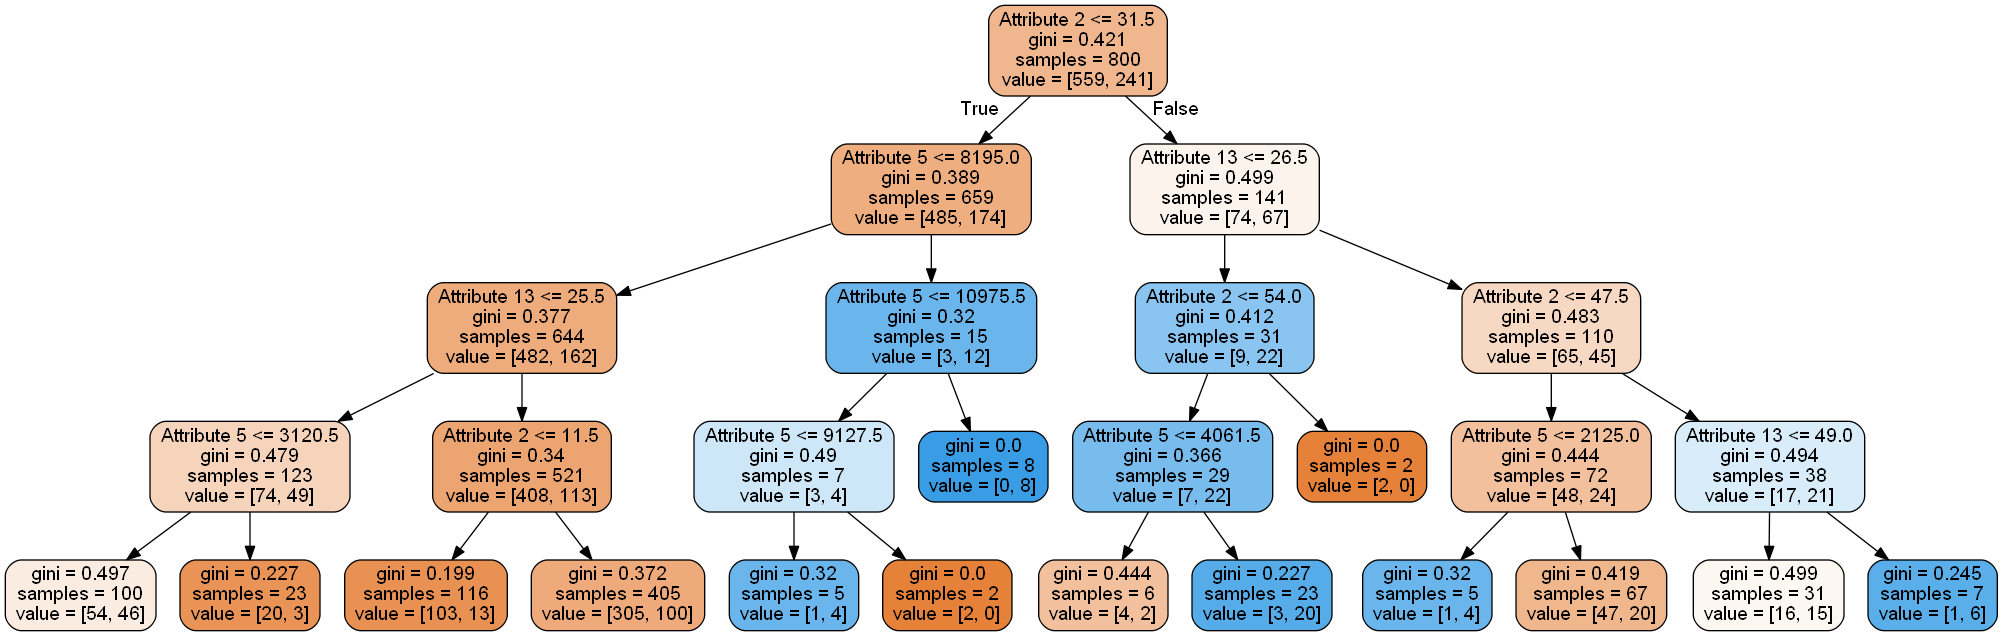

In [187]:
dot_data = StringIO()  
export_graphviz(dtforbins, out_file=dot_data,feature_names=num_attrs,filled=True,rounded=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())

The dictionary `colbins` below contains the boundaries of the bins for Attributes 2, 5, and 13 as dictated by the decision tree classifier above.

Note that this is only one way to discretize these continuous variables. For instance, another way to divide these attributes into buckets is by making bins of either equal widths or equal number of samples.

In [188]:
colbins = { "Attribute 2": [0, 11.5, 31.5, 47.5, 54, 70],
            "Attribute 5": [0, 2125, 3120.5, 4061.5, 8195, 9127.5, 10975.5, 19000],
            "Attribute 13":[0, 26.5, 49, 80] }

num_pip_4 = Pipeline([
            ("select_numeric", mthelp.ColumnSelector( num_attrs )),
            ("bins", mthelp.ConvToBins( colbin=colbins )),
            ("ohe", mthelp.DataFrameOHE())
            ])
cat_pip_4 = cat_pip_3
pre_pip_4 = mthelp.PandasFeatureUnion(transformer_list=[
            ("numeric", num_pip_4),
            ("categorical", cat_pip_4)
            ])

In [189]:
X_train_4 = pre_pip_4.fit_transform(train_data)
X_train_4.head()

,"Attribute 2_(0.0, 11.5]","Attribute 2_(11.5, 31.5]","Attribute 2_(31.5, 47.5]","Attribute 2_(47.5, 54.0]","Attribute 2_(54.0, 70.0]","Attribute 5_(0.0, 2125.0]","Attribute 5_(2125.0, 3120.5]","Attribute 5_(3120.5, 4061.5]","Attribute 5_(4061.5, 8195.0]","Attribute 5_(8195.0, 9127.5]",...,Attribute 12_A121,Attribute 12_Oth,Attribute 14_A141,Attribute 14_A142,Attribute 14_A143,Attribute 15_A151,Attribute 15_A152,Attribute 15_A153,Attribute 20_A201,Attribute 20_A202
29,0,0,0,0,1,0,0,0,1,0,...,0,1,0,0,1,0,1,0,1,0
535,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,1,1,0,0,1,0
695,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1,1,0,0,1,0
557,0,1,0,0,0,0,0,0,1,0,...,0,1,1,0,0,0,1,0,1,0
836,0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,1,0,1,0,1,0


### <span style="color:blue"> Logistic trial 4: Bucketizing the numerical variables</span>

After converting the numerical values into categorical variables are fed into a logistic regression model. Other categorical variables and feature engineering done in Logistic trial 3 was also done in this model.

In [190]:
log4 = LogisticRegression(solver="liblinear")
log4.fit(X_train_4, y_train)
y_pred_log4 = log4.predict(X_train_4)

Below are the results of the logistic regression that used the bucketized numerical variables. This shows an improvement in the accuracy compared to the previous best version of the logistic model.

In [191]:
cv_acc_log4 = cross_val_score(log4, X=X_train_4, y=y_train, cv=10, scoring="accuracy")
acc_log4 = cv_acc_log4.mean()
print(cv_acc_log4)
print("Logistic model (Trial 3) accuracy: {:0.2%}".format(acc_log3))
print("Logistic model (Trial 4) accuracy: {:0.2%}".format(acc_log4))

[0.72839506 0.825      0.775      0.7        0.7875     0.7
 0.8        0.7875     0.7375     0.82278481]
Logistic model (Trial 3) accuracy: 75.50%
Logistic model (Trial 4) accuracy: 76.64%


The model not only shows an improvement in the accuracy of the overall model. It also shows an improvement in the precision and recall in predicting bad credit observations.

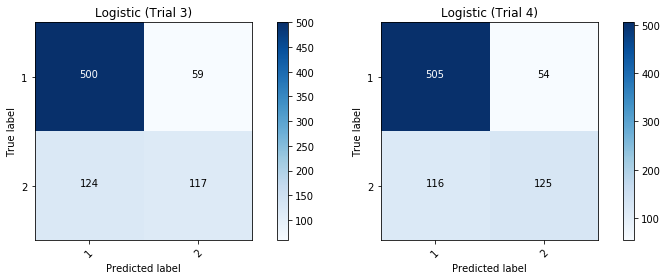

In [192]:
conf_log4 = confusion_matrix(y_true = y_train, y_pred = y_pred_log4)
mthelp.plot_confs(conf_log3, conf_log4, title1="Logistic (Trial 3)", title2="Logistic (Trial 4)")

In [193]:
print(classification_report(y_train, y_pred_log4, target_names=["Good", "Bad"], digits=4))

              precision    recall  f1-score   support

        Good     0.8132    0.9034    0.8559       559
         Bad     0.6983    0.5187    0.5952       241

   micro avg     0.7875    0.7875    0.7875       800
   macro avg     0.7558    0.7110    0.7256       800
weighted avg     0.7786    0.7875    0.7774       800



### <span style="color:blue"> Random forest: Using bucketized numerical variables and other significant categorical variables  </span>

A random forest model with default parameters is fitted with the engineered data set from Logistic trial 4 (i.e., set where insignificant variables and values are removed and numerical values are bucketized).

In [194]:
rf1 = RandomForestClassifier(n_estimators=100, random_state=42)
rf1.fit(X_train_4, y_train)
y_pred_rf1 = rf1.predict(X_train_4)

The resulting accuracy is close to, but still worse than the accuracy score of the fourth trail of the regression model.

In [195]:
cv_acc_rf1 = cross_val_score(rf1, X=X_train_4, y=y_train, cv=10, scoring="accuracy")
acc_rf1 = cv_acc_rf1.mean()
print(cv_acc_rf1)
print("Logistic model (Trial 4) accuracy: {:0.2%}".format(acc_log4))
print("Random forest (Trial 1) accuracy: {:0.2%}".format(acc_rf1))

[0.7654321  0.725      0.7375     0.725      0.7375     0.775
 0.8125     0.8        0.7125     0.73417722]
Logistic model (Trial 4) accuracy: 76.64%
Random forest (Trial 1) accuracy: 75.25%


The non-cross validated accuracy score below is almost equal to 100%. The significant reduction in the cross validated accuracy (75%) is a sign of overfitting.

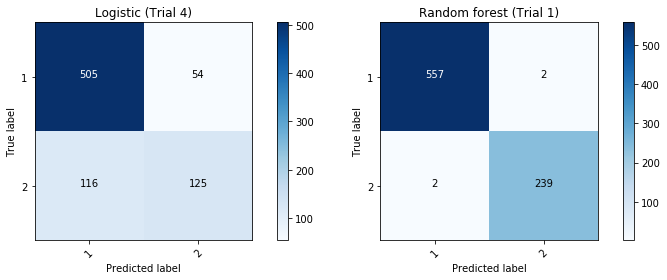

In [196]:
conf_rf1 = confusion_matrix(y_true = y_train, y_pred = y_pred_rf1)
mthelp.plot_confs(conf_log4, conf_rf1, title1="Logistic (Trial 4)", title2="Random forest (Trial 1)")

In [197]:
print(classification_report(y_train, y_pred_rf1))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       559
           2       0.99      0.99      0.99       241

   micro avg       0.99      0.99      0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



## <span style="color:blue"> Conclusion and discussion of results </span>

Out of all the models created, the one that showed the best accuracy score under a ten-fold cross validation of 76.64% is the fourth iteration of the logistic regression model. To repeat, this model requires the following feature engineering:
* Bucketize numerical attributes 2, 5, and 13
* Include categorical attributes 1, 3, 4, 6, 7, 9, 12, 14, 15, and 20
* Combine certain values for attributes 3, 4, 7, and 12
* All the other attributes are ignored in the model

The motivation for these transformations are explained in the data exploration stage.

The primary advantages of using this model over the other models that were created are as follows:
* Uses the least attributes because it drops the unnecessary features
* Showed little underfitting, as evidenced by the very small difference between the model's accuracy without a cross validation and its accuracy with cross validation
* Unlike random forest, which showed almost the same ten-fold cross validation accuracy score, it is more interpretable, because it will output a list of coefficients for each feature used in the model

In [198]:
answer = mthelp.MidtermAnswer()

In [199]:
transform_function = answer.run_pipeline # This function is needed to transform raw data
credit_model = answer.fit(train_data) # This contains the fitted sklearn LogisticRegression model

In [200]:
y_pred_test = credit_model.predict(transform_function(X_test))

The accuracy score on the test set (77.5%) is very close to the ten-fold cross validation accuracy score done on the training set (76.64%). It is also close to in-sample accuracy score of the model equal to 78.75%. This shows that the model did not significanly lose accuracy when looking at out-of-sample predictions.

In [201]:
print(accuracy_score(y_test, y_pred_test))

0.775


As seen below, the primary problem with this model is its relative weakness in correctly identifying bad credit data observations. In the test set, most of the values whose credit risk is bad are misclassified as good.

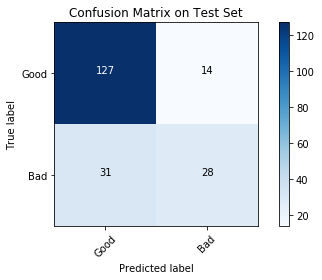

In [203]:
conf_test = confusion_matrix(y_true = y_test, y_pred = y_pred_test)
mthelp.plot_confusion_matrix(conf_test, classes=["Good", "Bad"], title="Confusion Matrix on Test Set")

In [202]:
print(classification_report(y_test, y_pred_test, target_names=["Good", "Bad"], digits=4))

              precision    recall  f1-score   support

        Good     0.8038    0.9007    0.8495       141
         Bad     0.6667    0.4746    0.5545        59

   micro avg     0.7750    0.7750    0.7750       200
   macro avg     0.7352    0.6876    0.7020       200
weighted avg     0.7633    0.7750    0.7625       200



## <span style="color:blue"> Recommendations: Modifications to the loss function </span>

As mentioned, the primary problem with the chosen model is its relative inability to predict bad borrowers with great precision and recall. One way to remedy this is to assign a greater cost in the loss function for misclassified bad borrowers compared to misclassified good borrowers. This gives higher priority to correctly predicting bad borrowers, but would negatively affect the ability to correctly identify good borrowers. Below is a potential implementation of this recommendation.

In [204]:
log_weights = LogisticRegression(solver="liblinear", class_weight={1:1, 2:5})
log_weights.fit(transform_function(train_data), y_train)
y_pred_log_weights = log_weights.predict(transform_function(train_data))

Notice that this model was able to greatly increase the number of correctly identified bad borrowers, but lost accuracy in correctly predicting good borrowers.

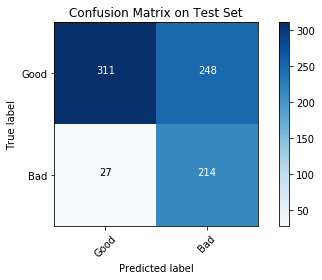

In [205]:
conf_weight = confusion_matrix(y_true = y_train, y_pred = y_pred_log_weights)
mthelp.plot_confusion_matrix(conf_weight, classes=["Good", "Bad"], title="Confusion Matrix on Test Set")

One way to set the `class_weight` parameter is to do another grid search and attempt to maximize accuracy, while making sure that the cost/weight for misclassified bad credit borrowers is higher than misclassified good borrowers. However, the most proper way to set this is by going back to the bank or the lender and asking for the actual costs of rejecting a good borrower (lost income) or accepting a bad borrower (defaults) to the business and applying these costs to the loss function.

Another potential way of modifying the loss function is by assigning different weights to each observation. The most logical weight that should be assigned to each observation is the loan amount. The higher the loan amount, the greater is the company's need to get the classification correctly. However, this will be relatively harder to optimize in `sklearn`.